#  0 - IMPORTS

In [2]:
import pandas as pd
import inflection
import math
import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np
from scipy.stats import skew, kurtosis
from scipy import stats


from boruta import BorutaPy
import pickle


from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

#Function calculates statistics

def calcula_estatistica(data):
    mean= round(np.mean(data),2)
    mode= round(stats.mode(data,)[0][0],2)
    median=round(np.median(data),2)
    var= round(np.var(data),2)
    std= round(np.std(data),2)
    coef_person= round(stats.skew(data),2)
    corf_kurtosis= round(kurtosis(data),2)
    msg= print('Media: {} \nModa: {}\nMediana: {}\nVariância: {}\nDesvio Padrão: {}\nSkew: {}\nKurtosis: {}'.format(mean, mode, median, var, std, coef_person, corf_kurtosis))

    return msg

#Function Calculates cramer V
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - ( k - 1 ) * ( r - 1) / (n - 1))
    kcorr = k - (k - 1) **2/(n - 1) 
    rcorr = r - (r - 1) **2/(n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr -1, rcorr -1) ) )

#Function Calculates MPE
def ml_percentage_error( model_name, y, yhat):
    mpe = np.mean((y - yhat) / y)

    return pd.DataFrame({'Model Name': model_name,
                        'MPE': mpe
                        }, index=[0])



#Function performance model
def ml_error( model_name, y, yhat):
    Rquadrado = metrics.r2_score(y, yhat) 
    mae =  metrics.mean_absolute_error(y, yhat)
    mape= metrics.mean_absolute_percentage_error(y, yhat)
    rmse= np.sqrt(metrics.mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse,
                        'R': Rquadrado}, index=[0])



# function Cross Validation

def cross_validation( x_training, kfold, model_name, model, verbose=False):

    mae_list= []
    mape_list= []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        
        if verbose:
            print('Kfold Number: {}'.format(k))

        
        #Start and end date validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #Filtering dataset

        training = x_training[x_training['date'] < validation_start_date]
        validation= x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #Training and Validation dataset
        #Training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #Validation
        xvalidation= validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m =model.fit(xtraining, ytraining)
        #Prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
    
        #Store performance of each Kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return  pd.DataFrame({  'Model Name': model_name,
                            'MAE CV':  np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' +   np.round( np.std( mae_list ), 2).astype(str),
                            'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round( np.std( mape_list ), 2).astype(str),
                            'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round( np.std( rmse_list ), 2).astype(str)}, index=[0])

## Loading data

In [4]:
df_sale_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw= pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw= pd.merge(df_sale_raw, df_store_raw, how='left', on= 'Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
409861,327,7,2014-06-29,0,0,0,0,0,0,c,c,1390.0,12.0,2004.0,0,NaN,NaN,NaN


# 1 - DESCRICAO DOS DADOS

In [6]:
df1 = df_raw.copy()

##  Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data Dimensions

In [9]:
print('Number of Rows {}'.format(df1.shape[0]))
print('Number of Cols {}'.format(df1.shape[1]))

Number of Rows 1017209
Number of Cols 18


## Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
#Convert columns to date
df1['date'] = pd.to_datetime(df1['date'])

## Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

##### Fillout NA

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
362005,398,2,2014-08-19,6475,685,1,1,0,1,c,c,1540.0,NaN,NaN,1,1.0,2012.0,"Jan,Apr,Jul,Oct"


    #Columns competition_distance 

        - I decided to add a much higher value, assuming this value, The store would have no direct competitor.
    
    #competition_open_since_month
    
        - Assuming the opening month of the store itself and putting it in the competitor's opening month.
        - reason: The opening date of the competitor in some cases was not filled.
    
    #competition_open_since_year

        - I used the same logic as the columns competition_open_since_month

    #promo2_since_week
    
        - Describes when the store starded participating in promo 2


In [14]:
#Treatment of columns with missing data

#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x.date.month if math.isnan(x.competition_open_since_month) else x.competition_open_since_month, axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x.date.year if math.isnan(x.competition_open_since_year) else x.competition_open_since_year, axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x.date.week if math.isnan(x.promo2_since_week) else x.promo2_since_week, axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x.date.year if math.isnan(x.promo2_since_year) else x.promo2_since_year, axis=1)

#promo_interval
month_map = {1: 'jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [15]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


In [16]:
df1.sample(5).T

,249005,903153,960234,98041,898419
store,562,789,1005,1037,515
day_of_week,4,6,4,2,3
date,2014-12-18 00:00:00,2013-04-13 00:00:00,2013-02-21 00:00:00,2015-05-05 00:00:00,2013-04-17 00:00:00
sales,23242,2438,5817,6759,5741
customers,3718,351,861,780,525
open,1,1,1,1,1
promo,1,0,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,b,a,a,a,d


## Change Types

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


## Descriptive Statistical

In [19]:
num_atributes = df1.select_dtypes( include=['int64', 'float64'])
cat_atributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Atributes

In [20]:
#Central Tendency - mean - median
ct1 = pd.DataFrame(num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_atributes.apply(np.median)).T

#Dispersion - STD, min, max, range, sken, Kurtosis
d1 = pd.DataFrame(num_atributes.apply(np.std)).T
d2 = pd.DataFrame(num_atributes.apply(min)).T
d3 = pd.DataFrame(num_atributes.apply(max)).T
d4 = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_atributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis() )).T

#Concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m



,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


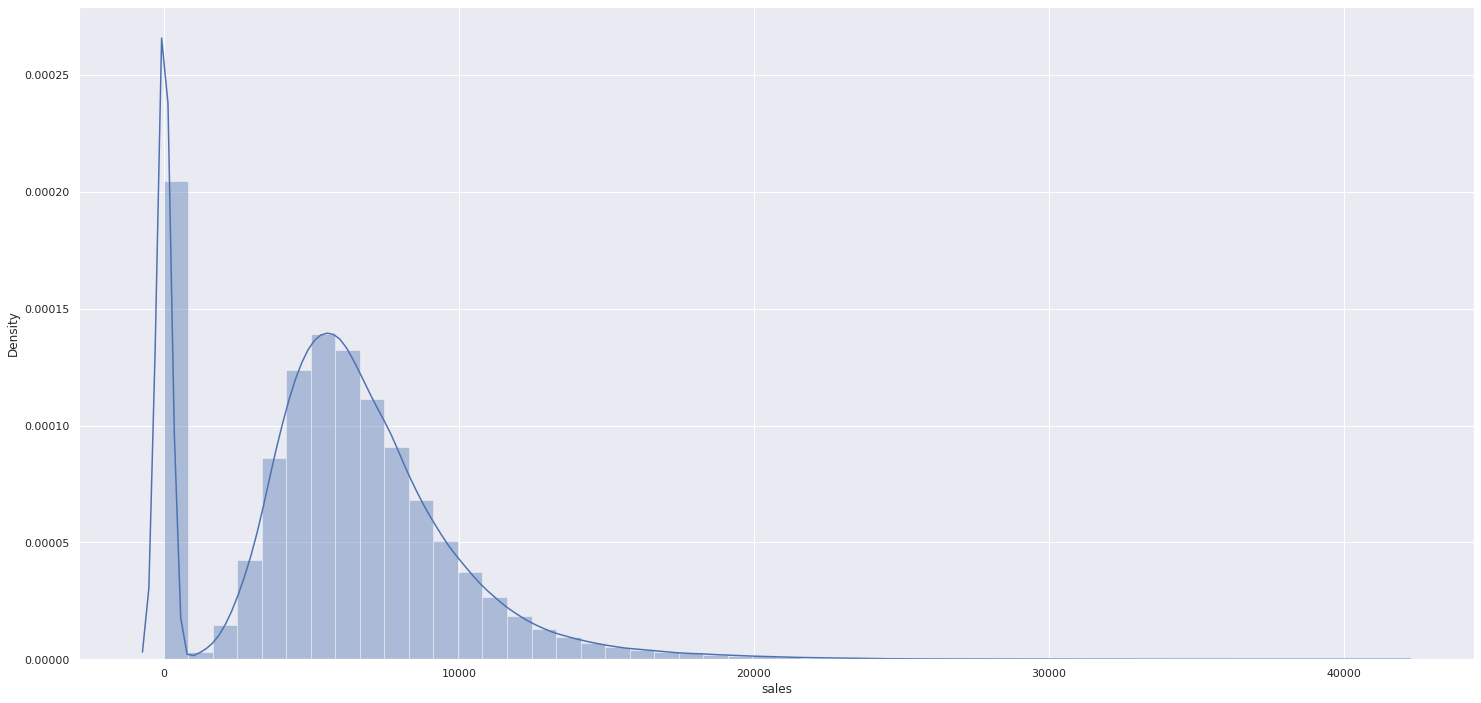

In [21]:
sns.distplot(df1['sales']);

### Categorical Atributes

In [22]:
cat_atributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

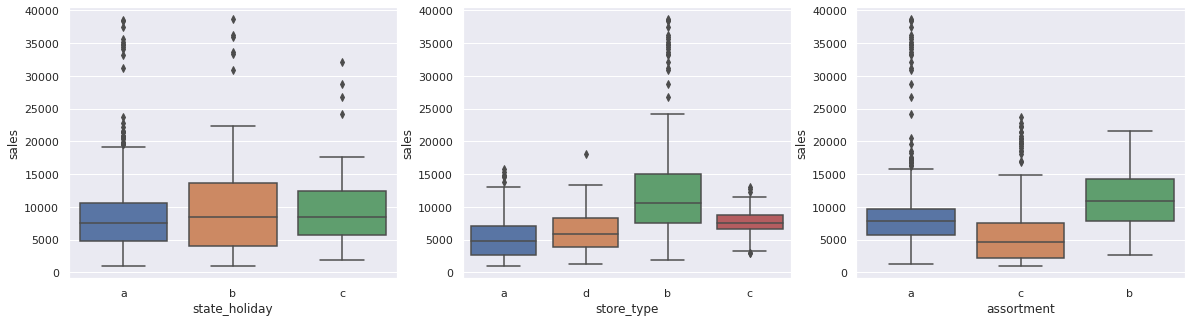

In [23]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0) ] #Retiramos o  acumulado de dias com venda 0

plt.figure(figsize = (20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' , y= 'sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type' , y= 'sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment' , y= 'sales', data=aux1);

In [24]:
aux1.groupby('state_holiday').sum()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
state_holiday,,,,,,,,,,,,,,
a,408504,2479,5890305,887746,694,386,104,6311520.0,4725,1395412,249,14922,1397199,46
b,82093,345,1433744,244599,145,50,139,1294180.0,859,291641,42,2363,291984,25
c,40713,286,691806,111415,71,0,71,146290.0,641,142749,20,3102,142945,2


# 2 - Feature Engineering

## Mapa Mental de Hipóteses

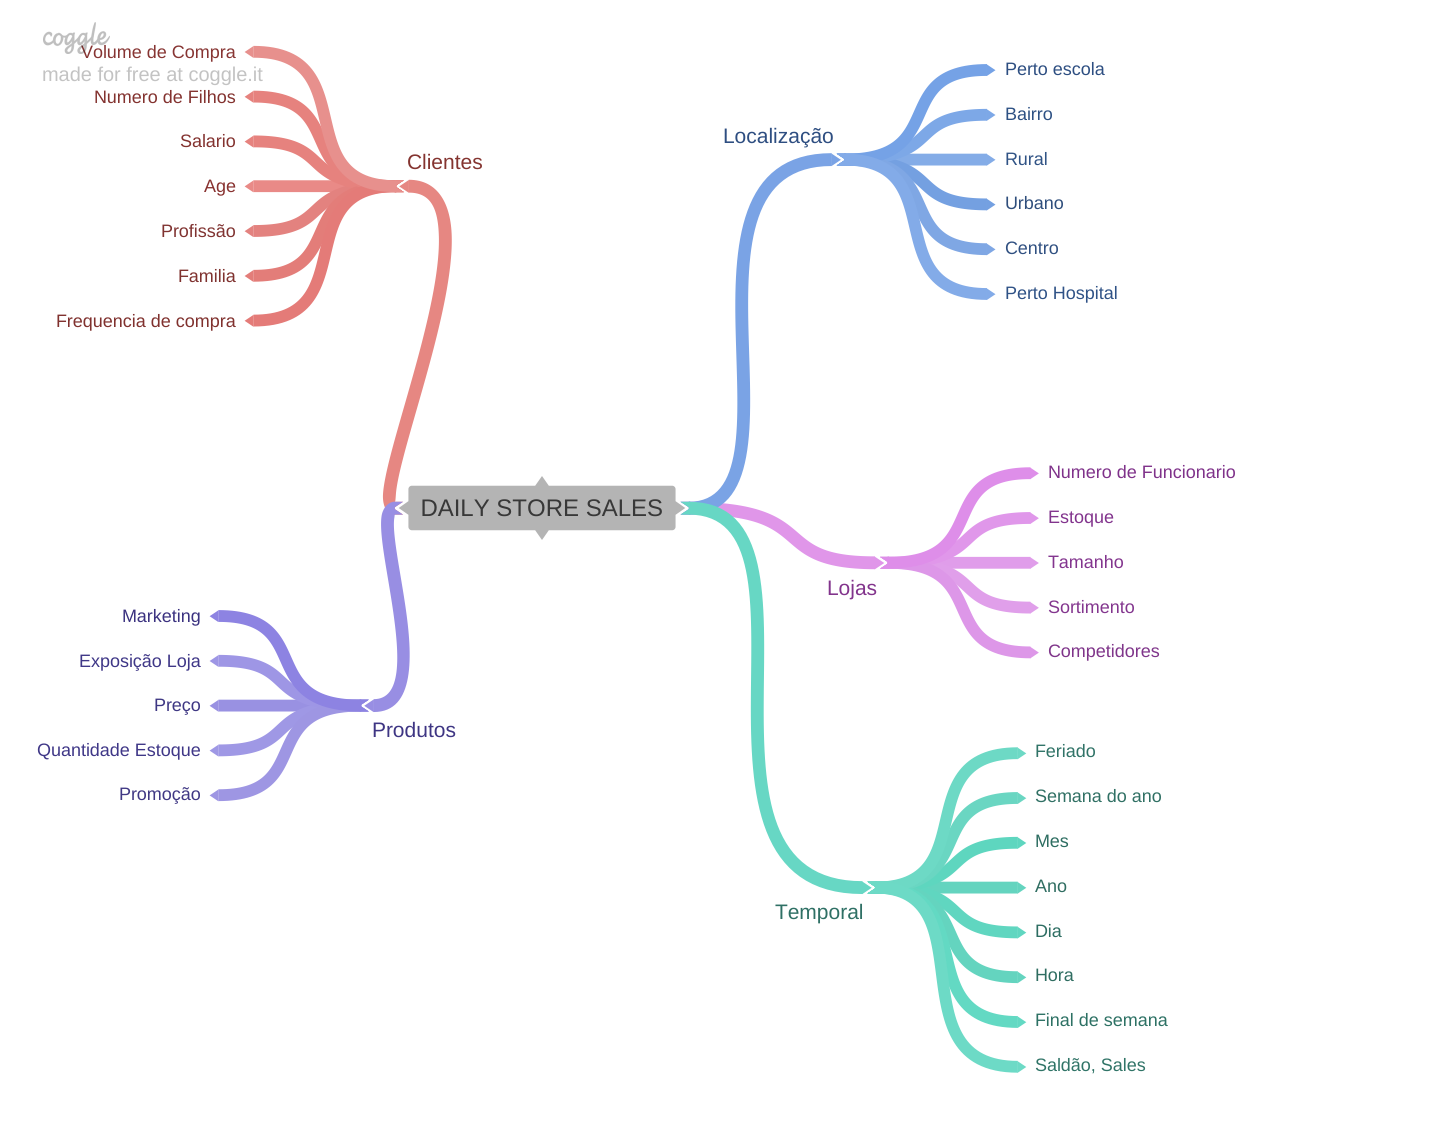

In [25]:
Image('img/MindMagHypothesis.png', )

## Criação das Hipóteses

### As Hipóteses Loja

**1,** Lojas com numero maior de funcionarios deveriam vender mais. (Não temos o numero de funcionario neste momento)

**2,** Lojas com maior capacidade de estoque deveriam vender mais. (Não temos a informação do estoque)

**3,** Lojas com maior porte deveriam vender mais. (Não temos o tamanho da loja)

**4,** Lojas com maior sortimento deveriam vender mais. 

**5,** Lojas com competidores mais proximos deveriam vender menos.

**6,** Lojas com competidores a mais tempo deveriam vender mais.

### As Hipoteses Produto

**1,** Lojas que investem mais em Marketing deveriam vender mais. (Não temos essa informação)

**2,** Lojas com maior exposição de produto deveria vender mais. (Não temos a quantidade de produtos)

**3,** Lojas com produtos e preço menor deveria vender mais. (Não temos os preços dos produtos)

**4,** Lojas com promoçoes mais agressivas (desconto maiores), deveriam vender mais. 

**5,** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6,** Lojas com mais dias de promoção deveriam vender mais.

**7,** Lojas com mais promoções consecutivas deveriam vender mais.

### Hipotese Tempo

**1,** Lojas aberta durante o feriado de Natal deveriam vender mais.

**2,** Lojas deveriam vender mais .

**3,** Lojas deveriam vender mais no segundo semetre do ano.

**4,** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5,** Lojas deveriam vender menos aos finanis de semana.

**6,** Lojas deveria vender menos durante os feriados escolares.

## Lista final de Hipóteses

- Criterio de priorização:
    - Voce tem ou não os dados disponivel no momento?
   
No metodo Crisp vamos priorizar os dados que temos para selecionar as hipóteses, caso la na frente o modelo estiver performando mal, coletamos os dados necessarios para respondermos as demais hipoteses e tentamos melhorar o modelo.

**1,** Lojas com maior sortimento deveriam vender mais.

**2,** Lojas com competidores mais proximos deveriam vender menos.

**3,** Lojas com competidores a mais tempo deveriam vender mais.

**4,** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5,** Lojas com mais dias de promoção deveriam vender mais.

**6,** Lojas com mais promoções consecutivas deveriam vender mais.

**7,** Lojas aberta durante o feriado de Natal deveriam vender mais.

**8,** Lojas deveriam vender mais .

**9,** Lojas deveriam vender mais no segundo semetre do ano.

**10,** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11,** Lojas deveriam vender menos aos finanis de semana.

**12,** Lojas deveria vender menos durante os feriados escolares.

In [26]:
df2 = df1.copy()

In [27]:
df2.head(1)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0


## Feature Engineering 

In [28]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days= 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

#assortmente
dict = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df2['assortment'] = df2['assortment'].map(dict)

#state holiday
dict1 = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0':'regular_day'}
df2['state_holiday'] = df2['state_holiday'].map(dict1)


In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3 - Filtragem de Variável

In [30]:
df3 = df2.copy()

## Filtragem das linhas

In [31]:
#Coluna open (O que me interessa são as vendas das lojas aberta, neste caso 1)

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Seleção das Colunas

In [32]:
cols_drop = ['customers', 'open', 'month_map', 'promo_interval']
df3.drop(cols_drop, axis=1, inplace=True)

In [33]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


# 4 - Analise Exploratória dos Dados

In [34]:
df4 = df3.copy()

## Analise Univariada

### Response Variable

Media: 6955.96 
Moda: 5674
Mediana: 6369.0
Variância: 9633659.34
Desvio Padrão: 3103.81
Skew: 1.59
Kurtosis: 4.85


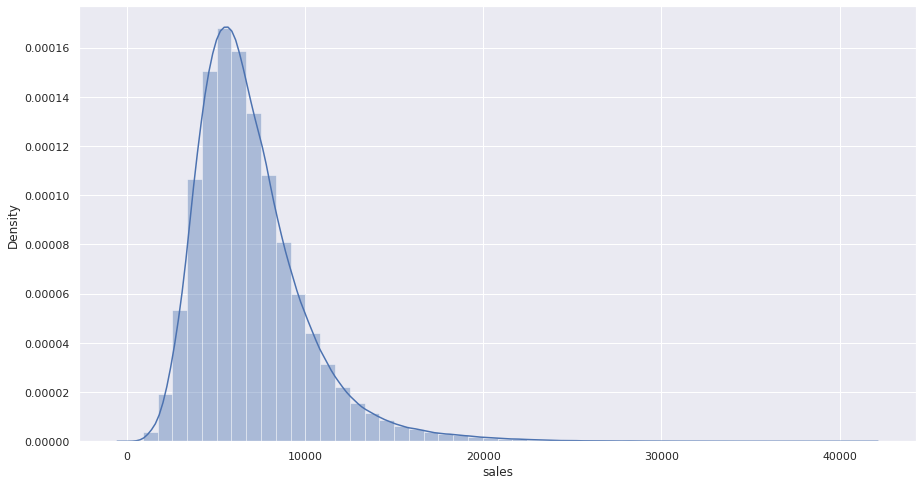

In [35]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.distplot(df4['sales'])
calcula_estatistica(df4['sales'])

#Temos uma variavel com uma assimetria positiva

### Numerical Variable

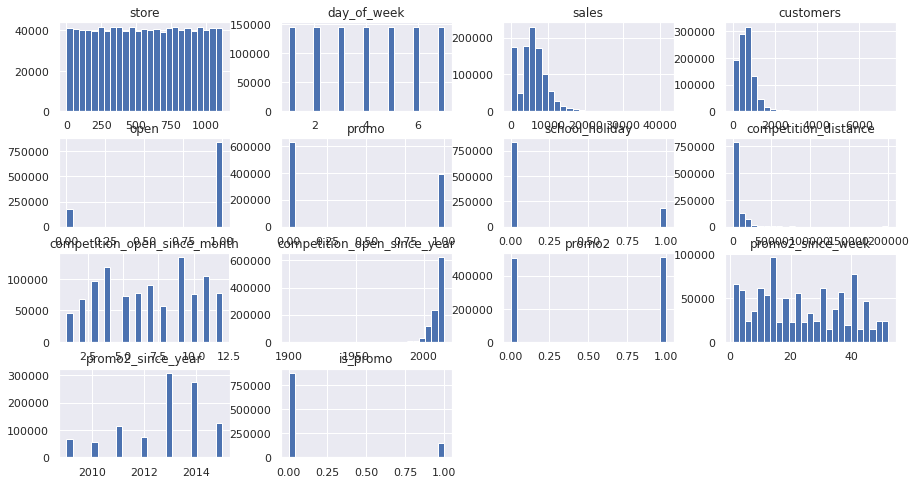

In [36]:
num_atributes.hist(bins=25);

### Categorical Variable

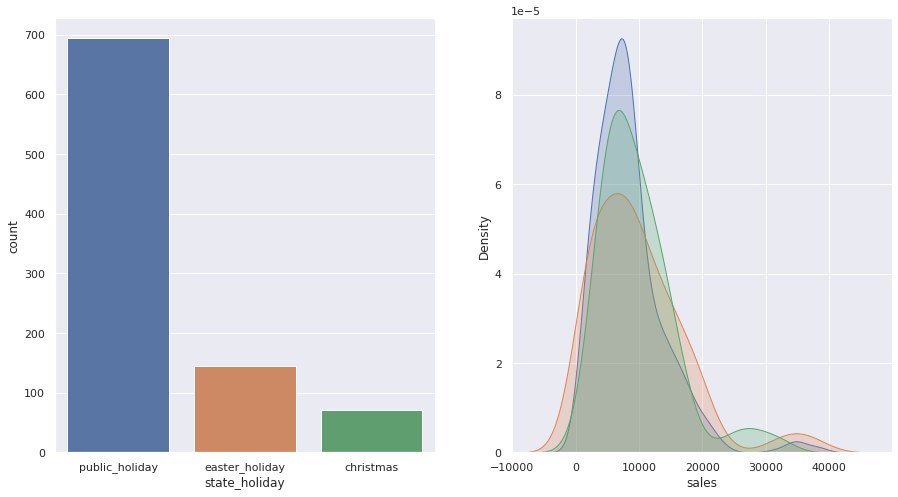

In [37]:
#state_holiday (Feriado)
plt.subplot(1, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']

sns.set(rc = {'figure.figsize':(40,15)})
sns.countplot(aux['state_holiday'])

plt.subplot(1, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);

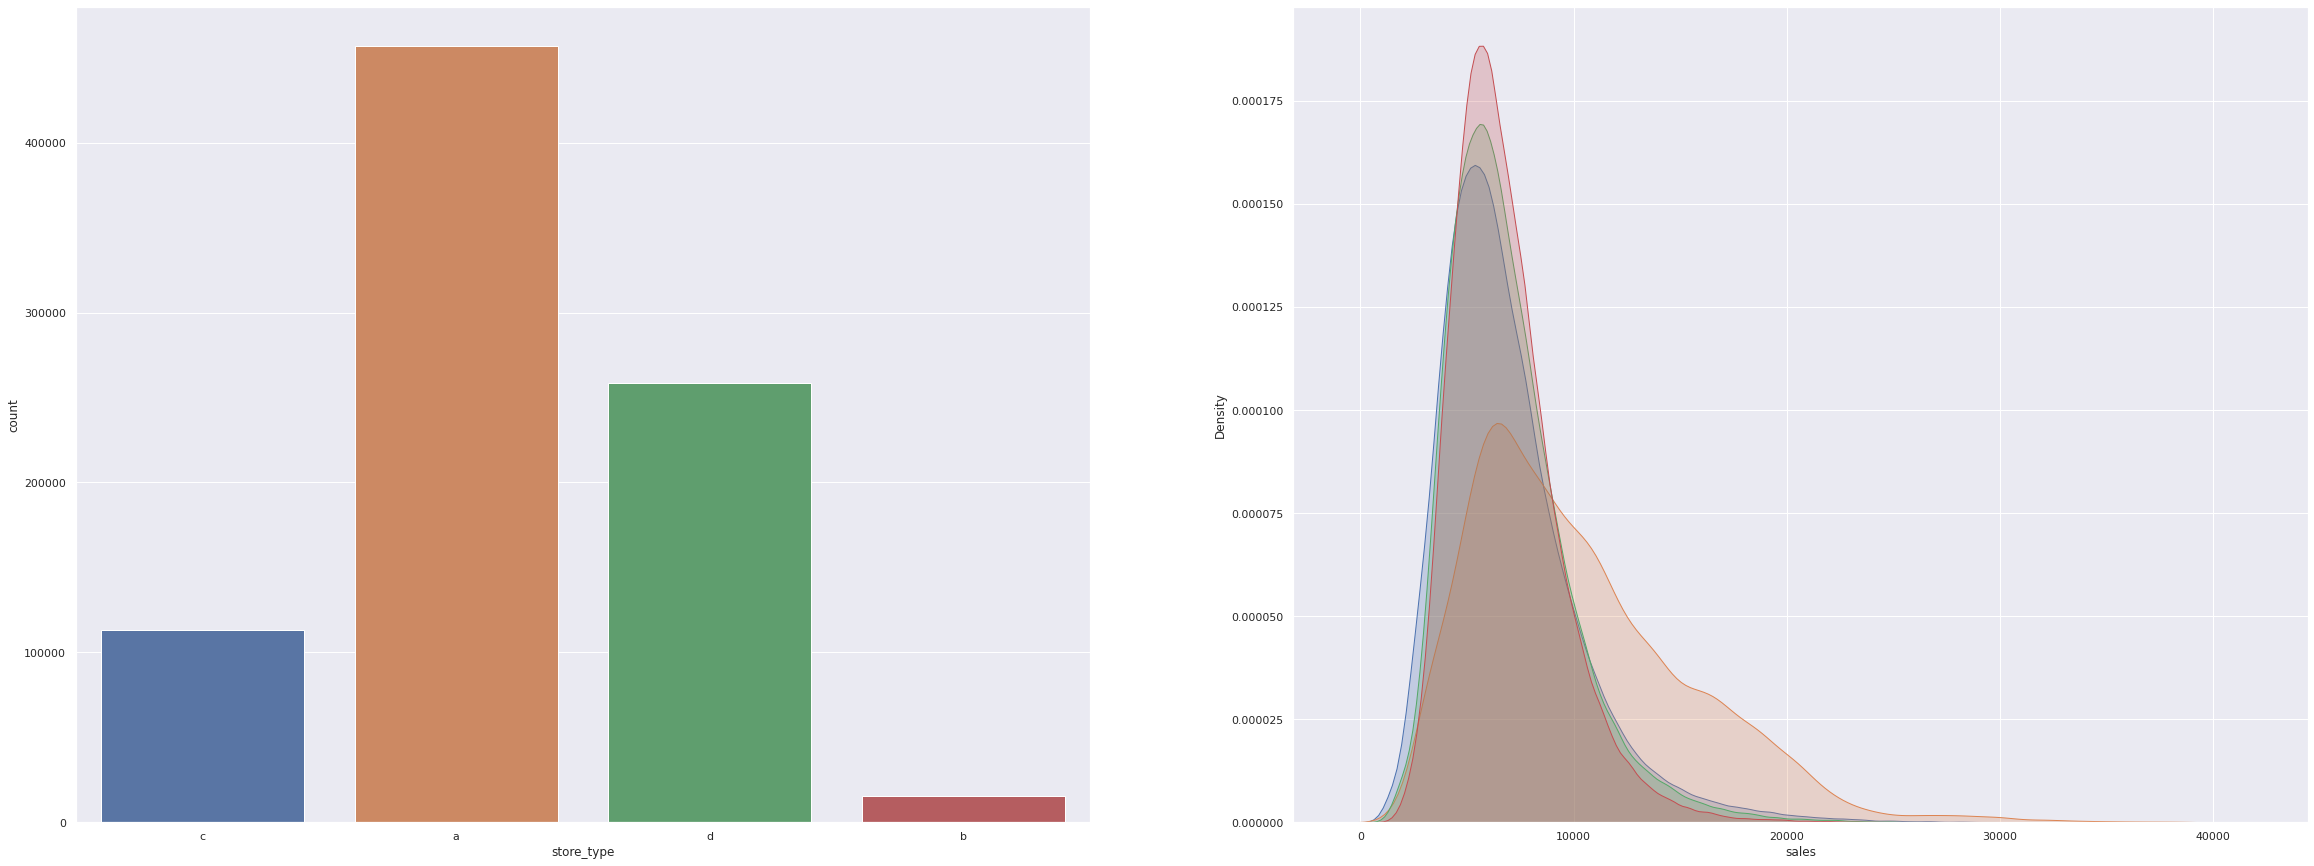

In [38]:
#Store_type
plt.subplot(1, 2, 1)

sns.set(rc = {'figure.figsize':(40,15)})
sns.countplot(df4['store_type'])

plt.subplot(1, 2, 2)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);

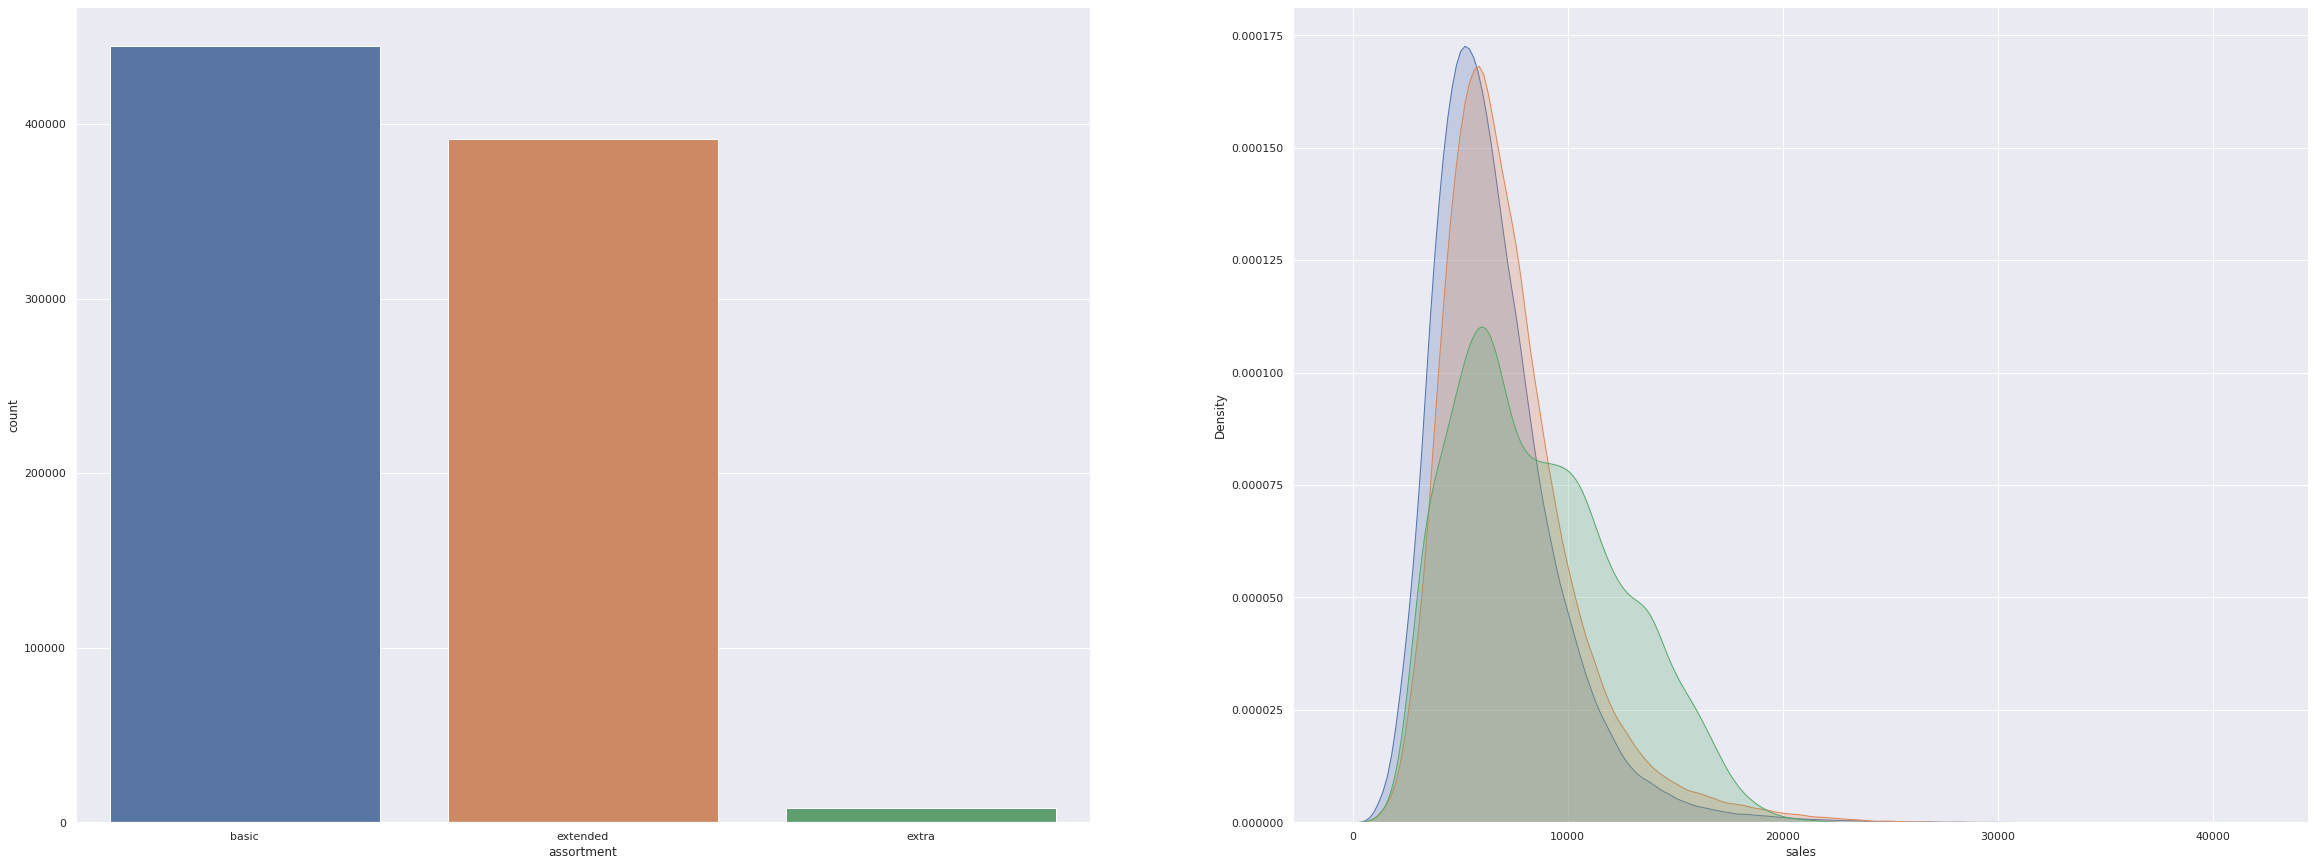

In [39]:
plt.subplot(1, 2, 1)

sns.set(rc = {'figure.figsize':(40,15)})
sns.countplot(df4['assortment'])

plt.subplot(1, 2, 2)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## Analise Bivariada

### H1 - Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO VENDEM MENOS.



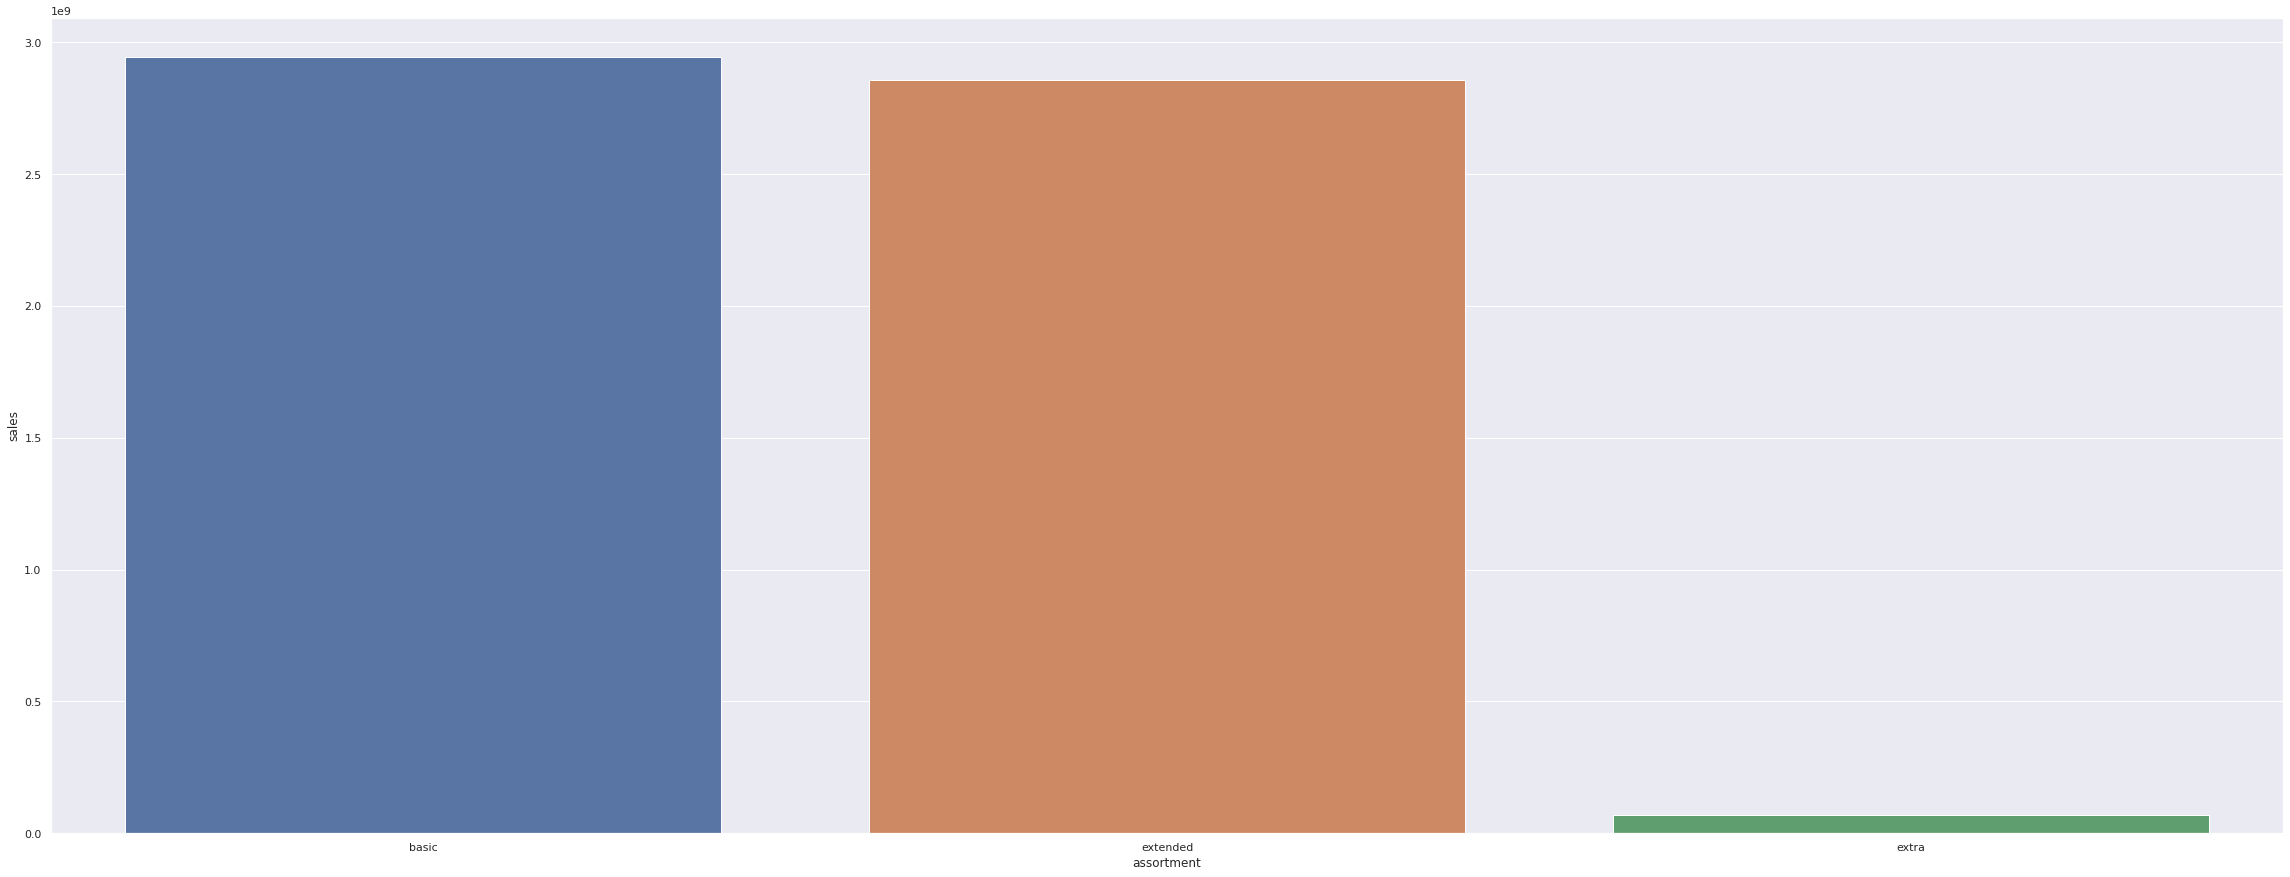

In [40]:
aux1= df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

sns.set(rc = {'figure.figsize':(40,15)})
sns.barplot(x='assortment', y='sales', data=aux1);


<AxesSubplot:xlabel='year_week'>

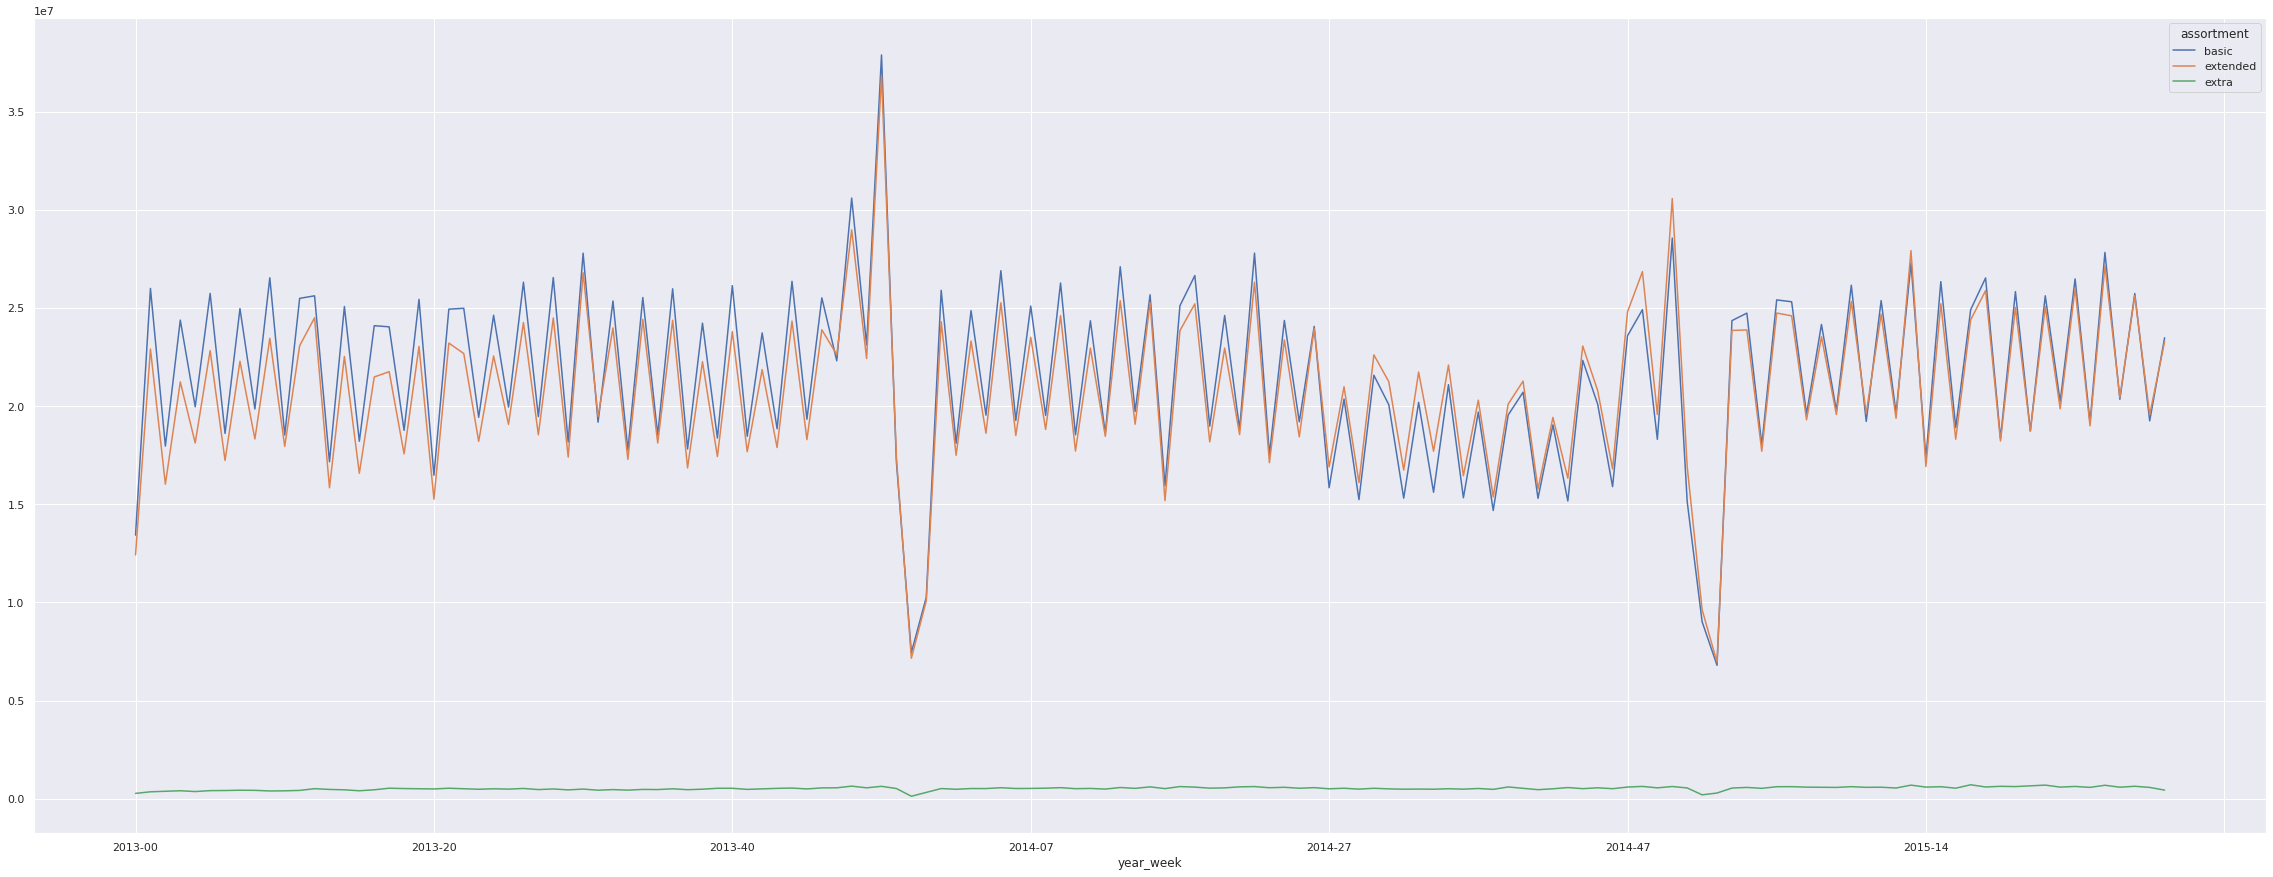

In [41]:
aux2= df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index= 'year_week', columns='assortment', values= 'sales').plot()


### H2. Lojas com competidores mais proximos deveriam vender menos.
**FALSA** Lojas com competidores proximos vendem mais.

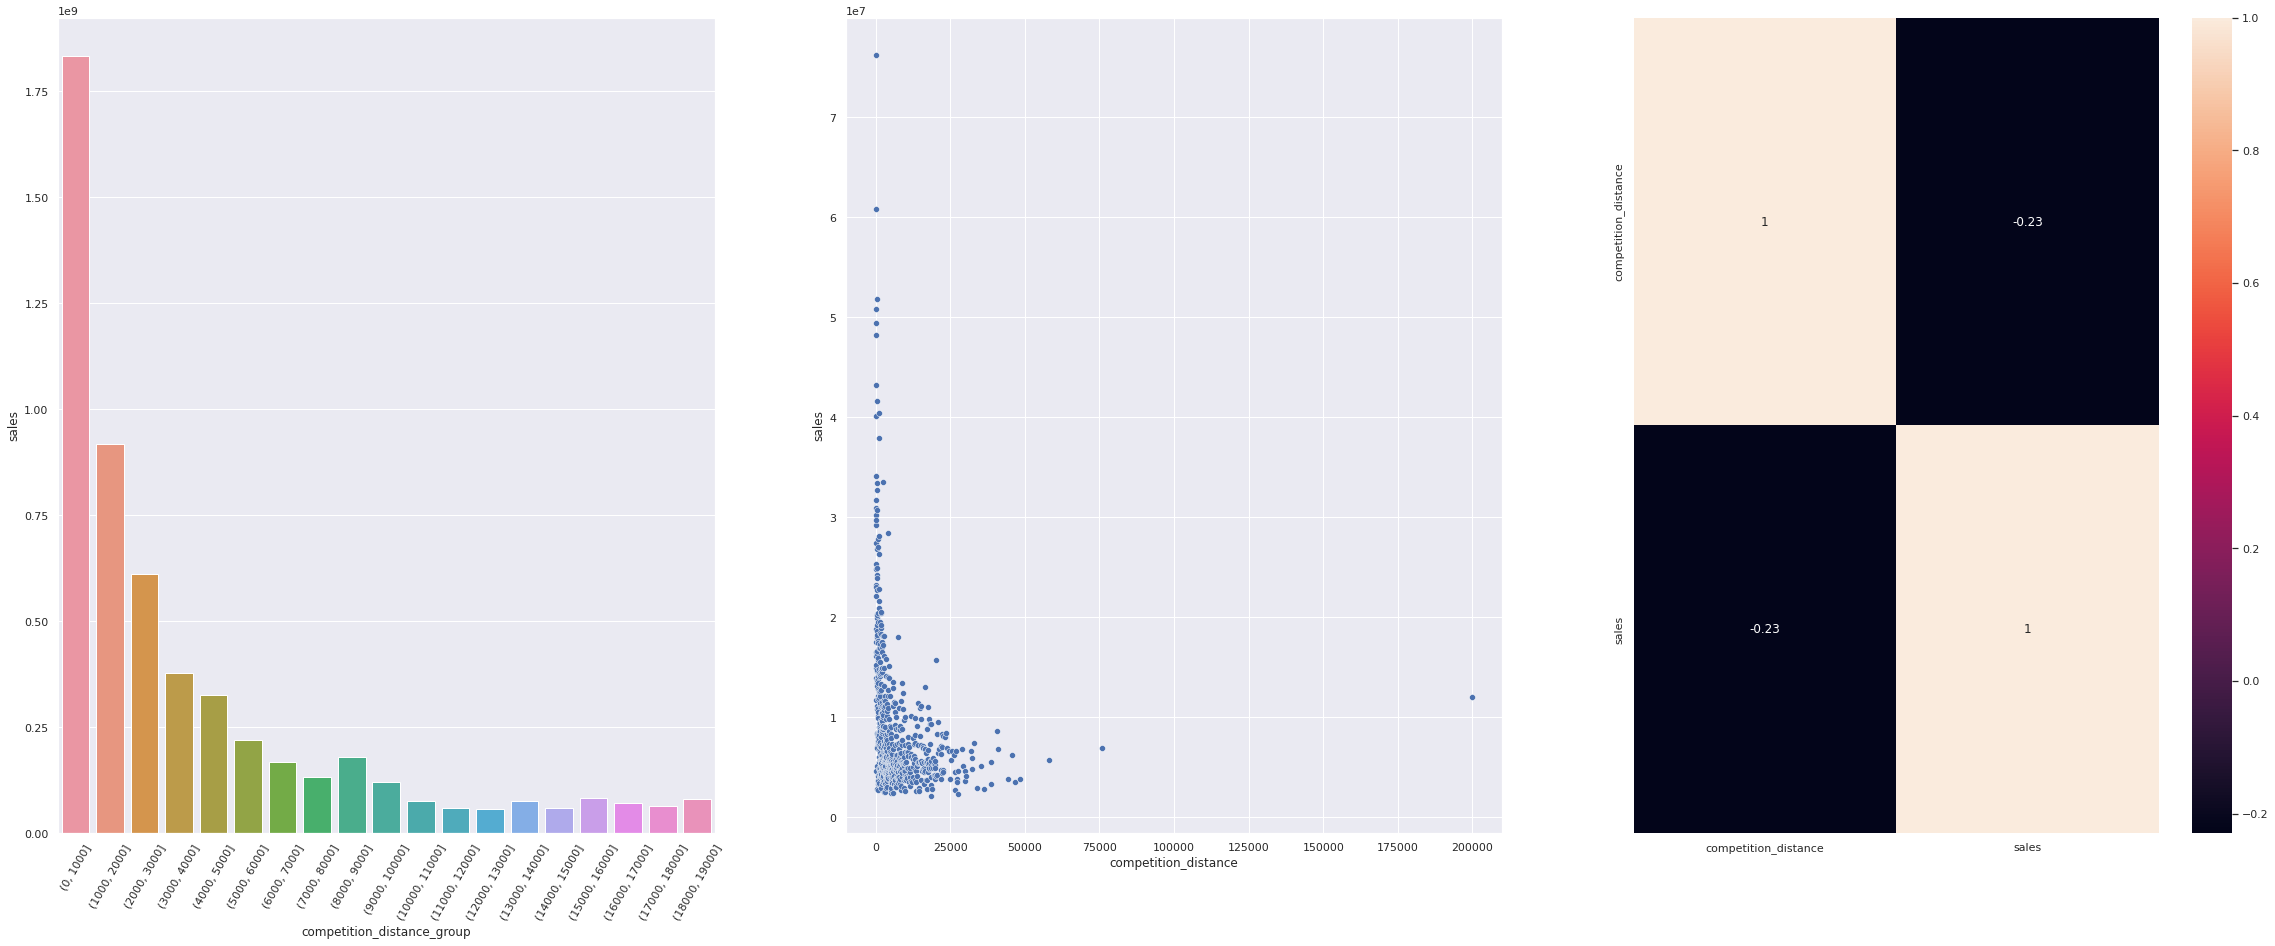

In [42]:
aux1= df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins= list(np.arange(0, 20000,1000))
aux1['competition_distance_group']= pd.cut(aux1['competition_distance'], bins=bins)

aux2= aux1[['competition_distance_group', 'sales']].groupby('competition_distance_group').sum().reset_index()

sns.set(rc = {'figure.figsize':(40,15)})
plt.subplot(1, 3, 1)
sns.barplot(x='competition_distance_group', y='sales', data=aux2)
plt.xticks(rotation=60);

plt.subplot(1, 3, 2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** Quanto mais recente é o competidor mais vende.

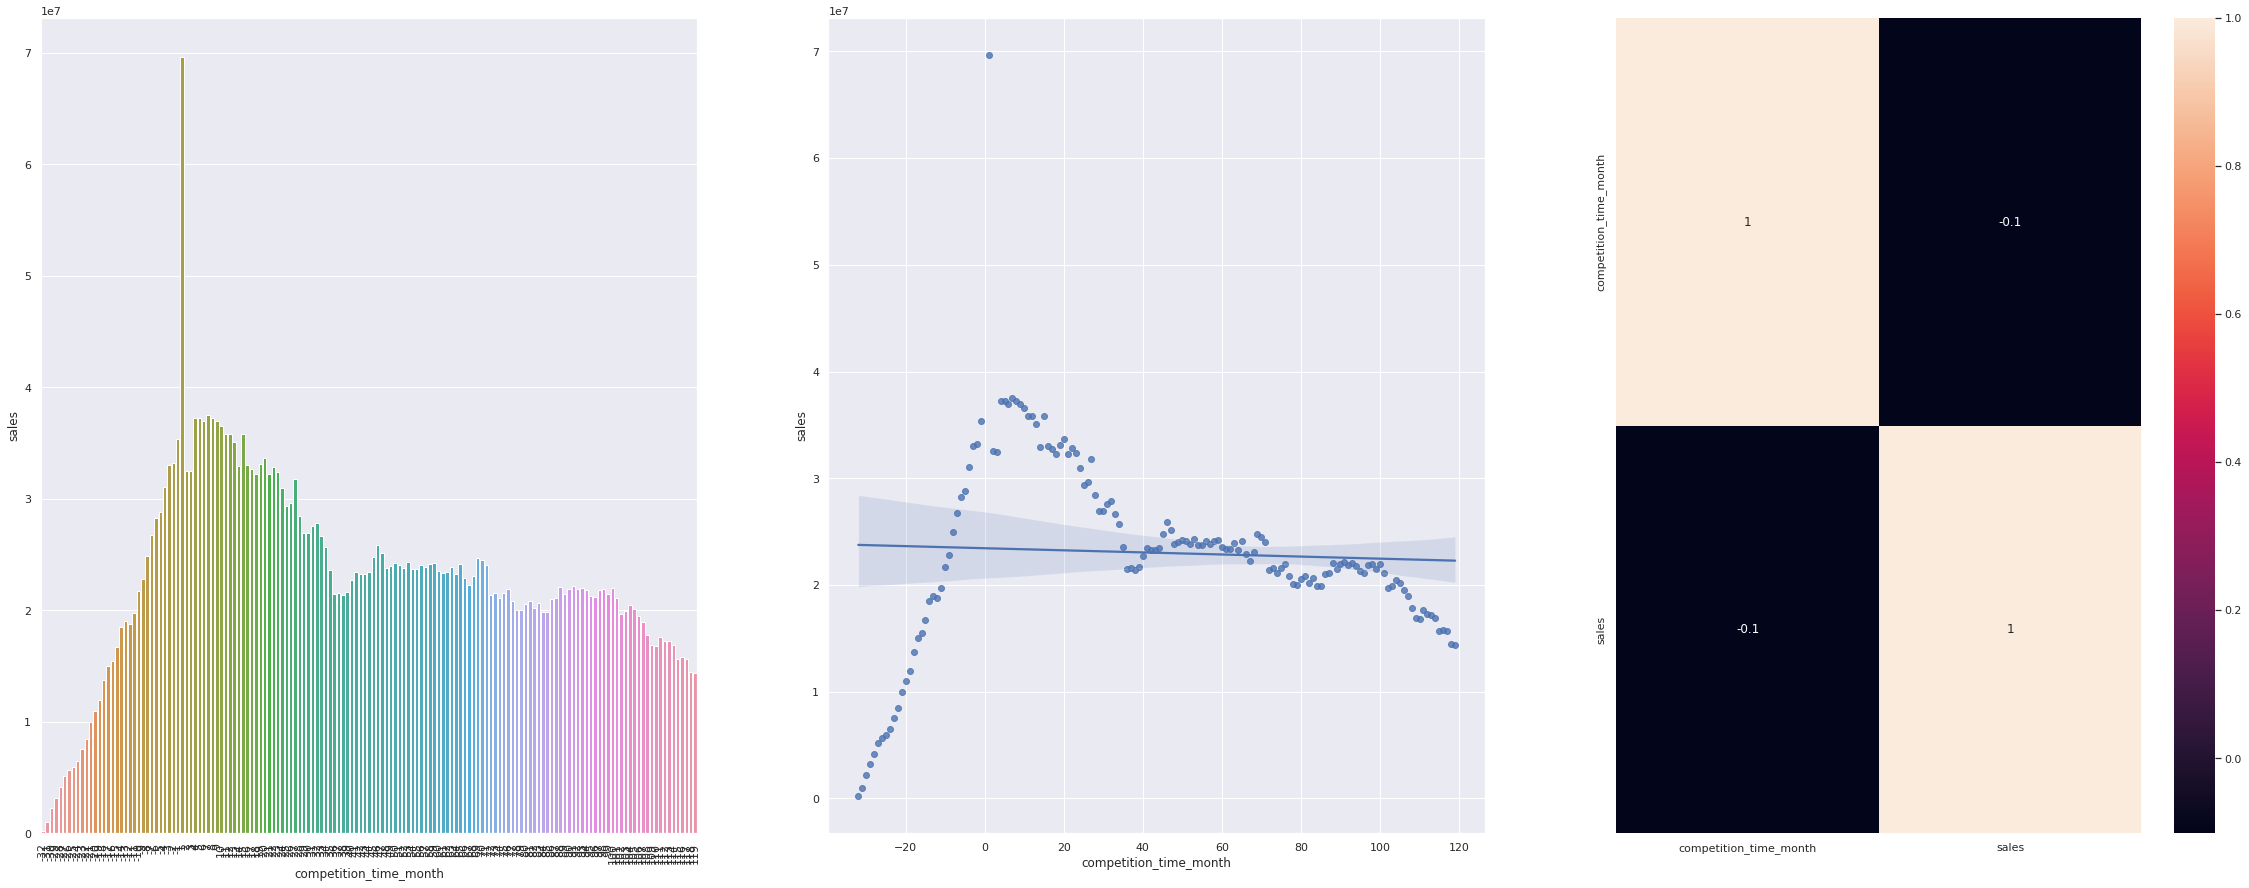

In [43]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

aux2= aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

sns.set(rc = {'figure.figsize':(40,15)})

plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks( rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4 Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção

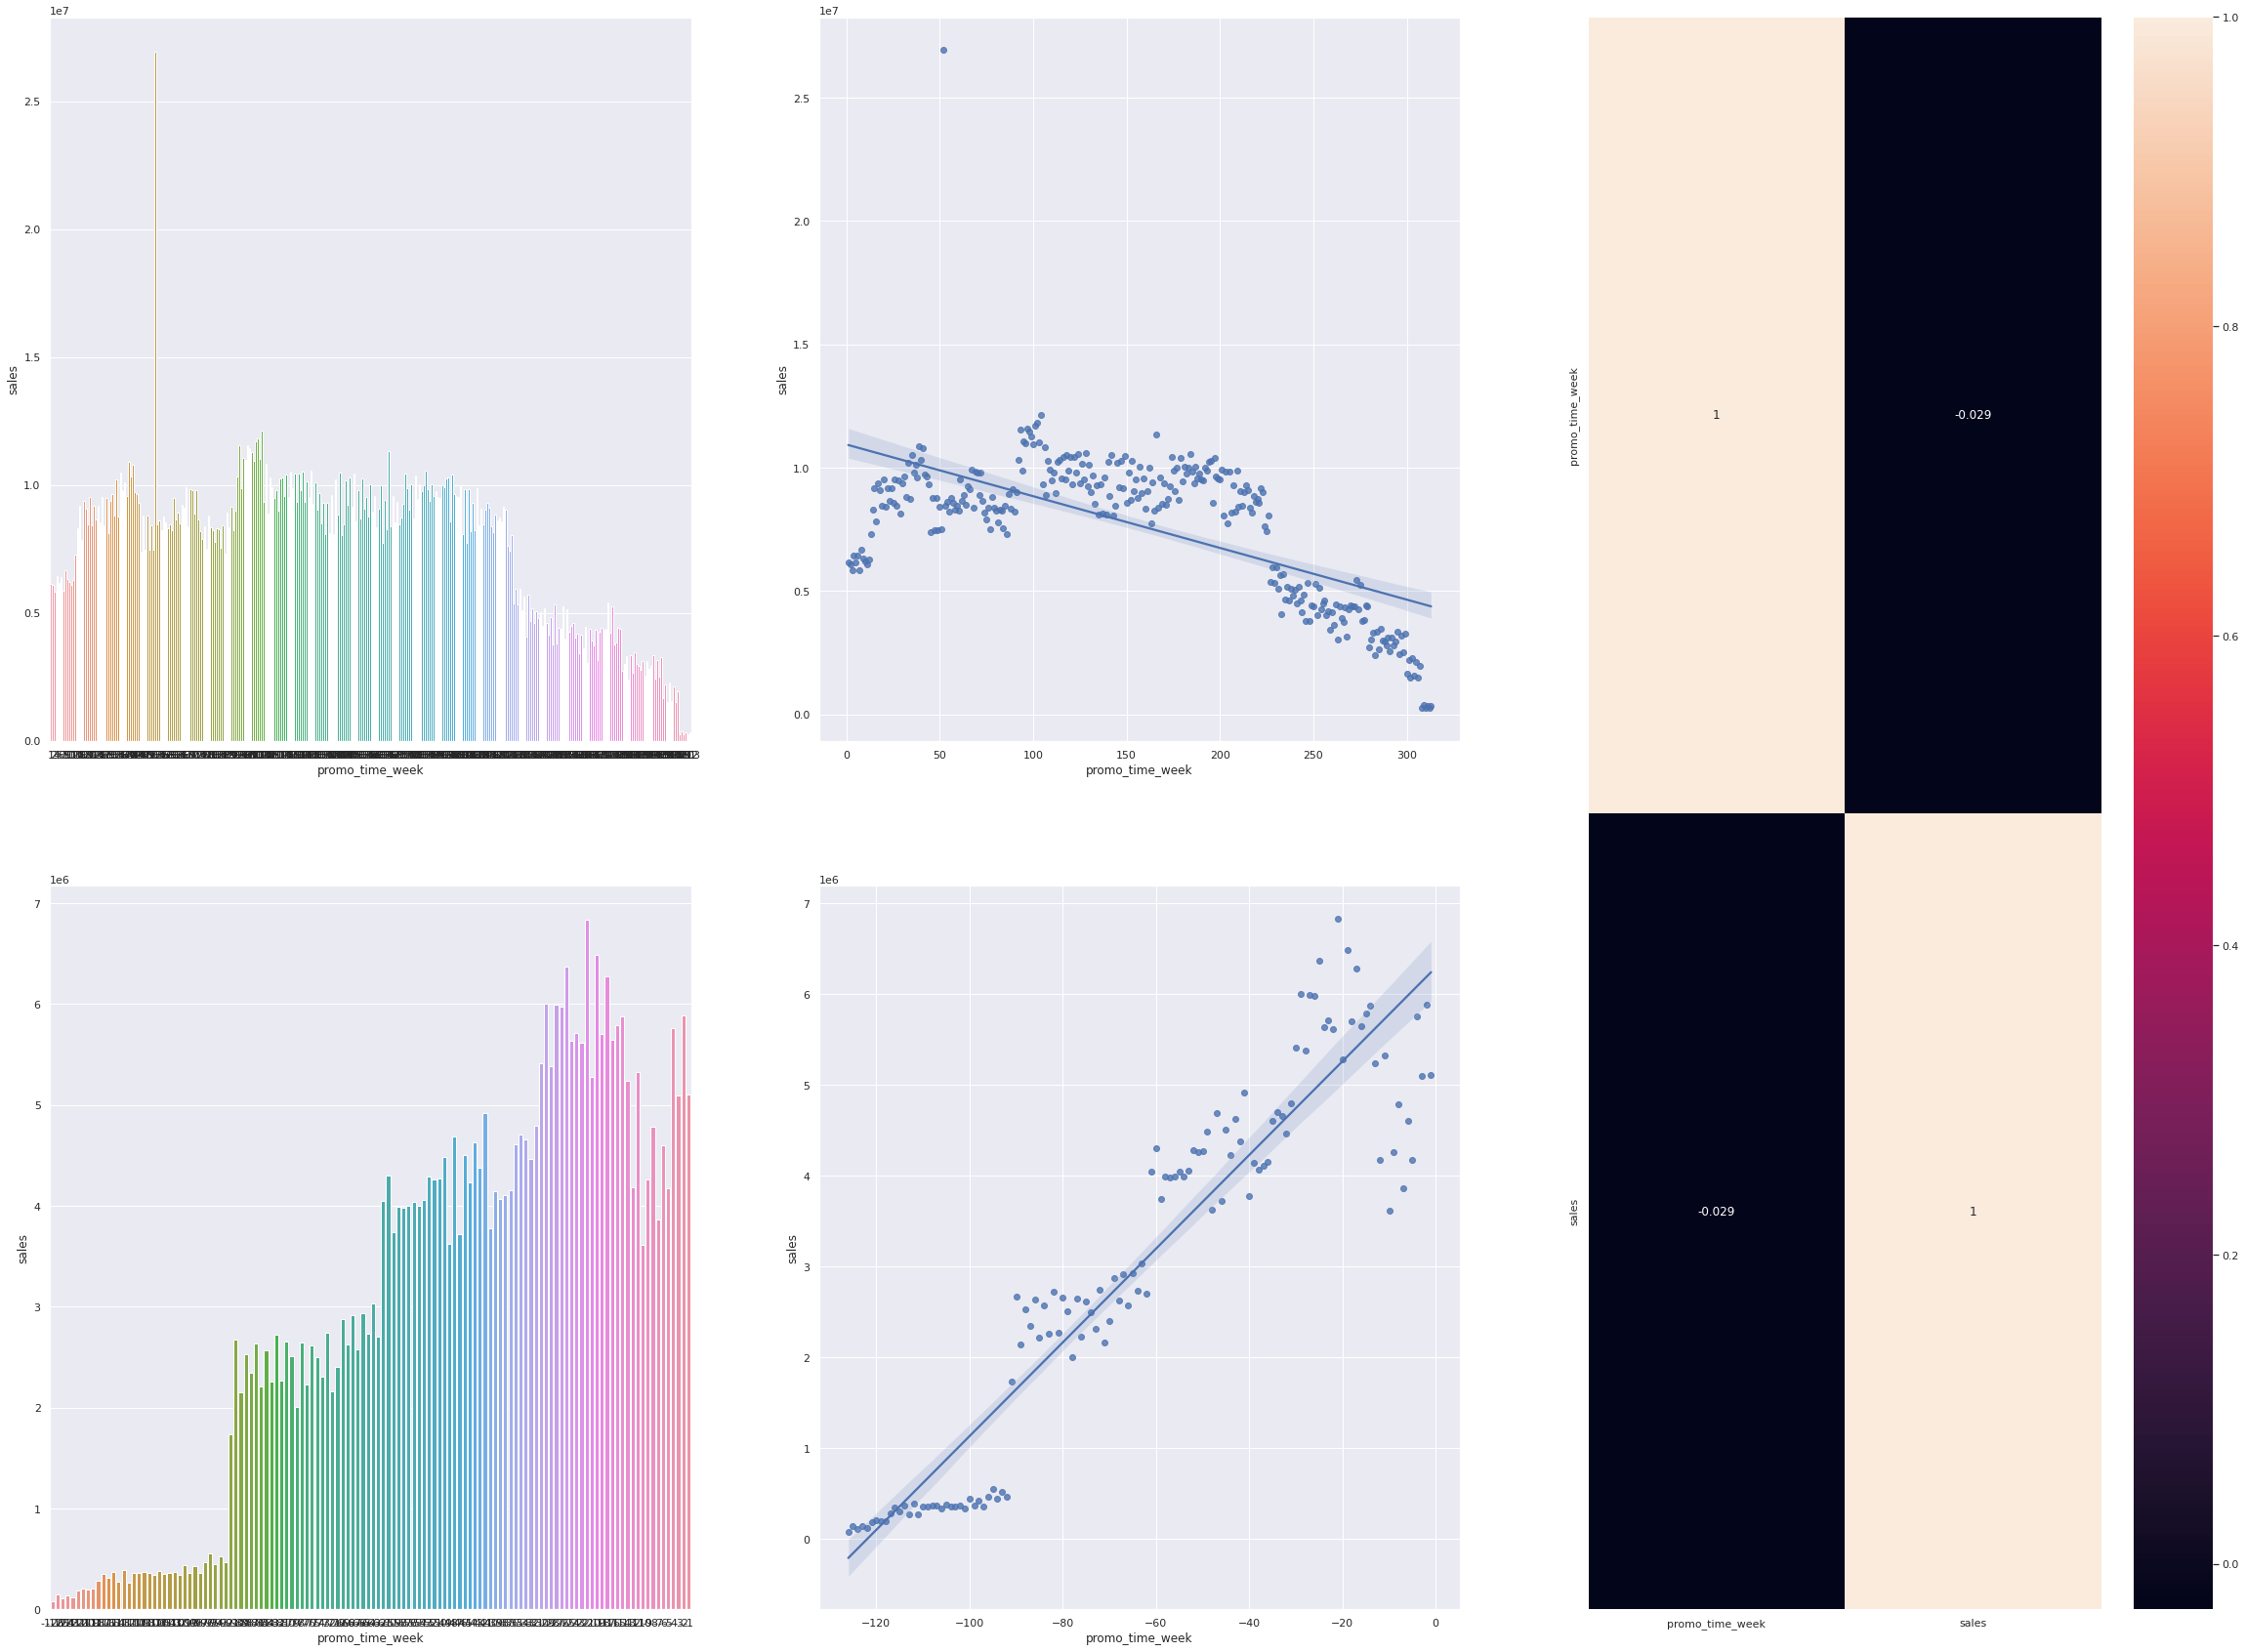

In [44]:
import matplotlib.gridspec as gridspec

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x='promo_time_week', y='sales', data=aux1);

sns.set(rc = {'figure.figsize':(40,30)})
grid= gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2= aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
#plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)


plt.subplot(grid[1,0])
aux3= aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
#plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### <s>H5 Lojas com mais dias de promoção deveriam vender mais.</s>

### H6 Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [45]:
df4['promo'].value_counts()

0    467463
1    376875
Name: promo, dtype: int64

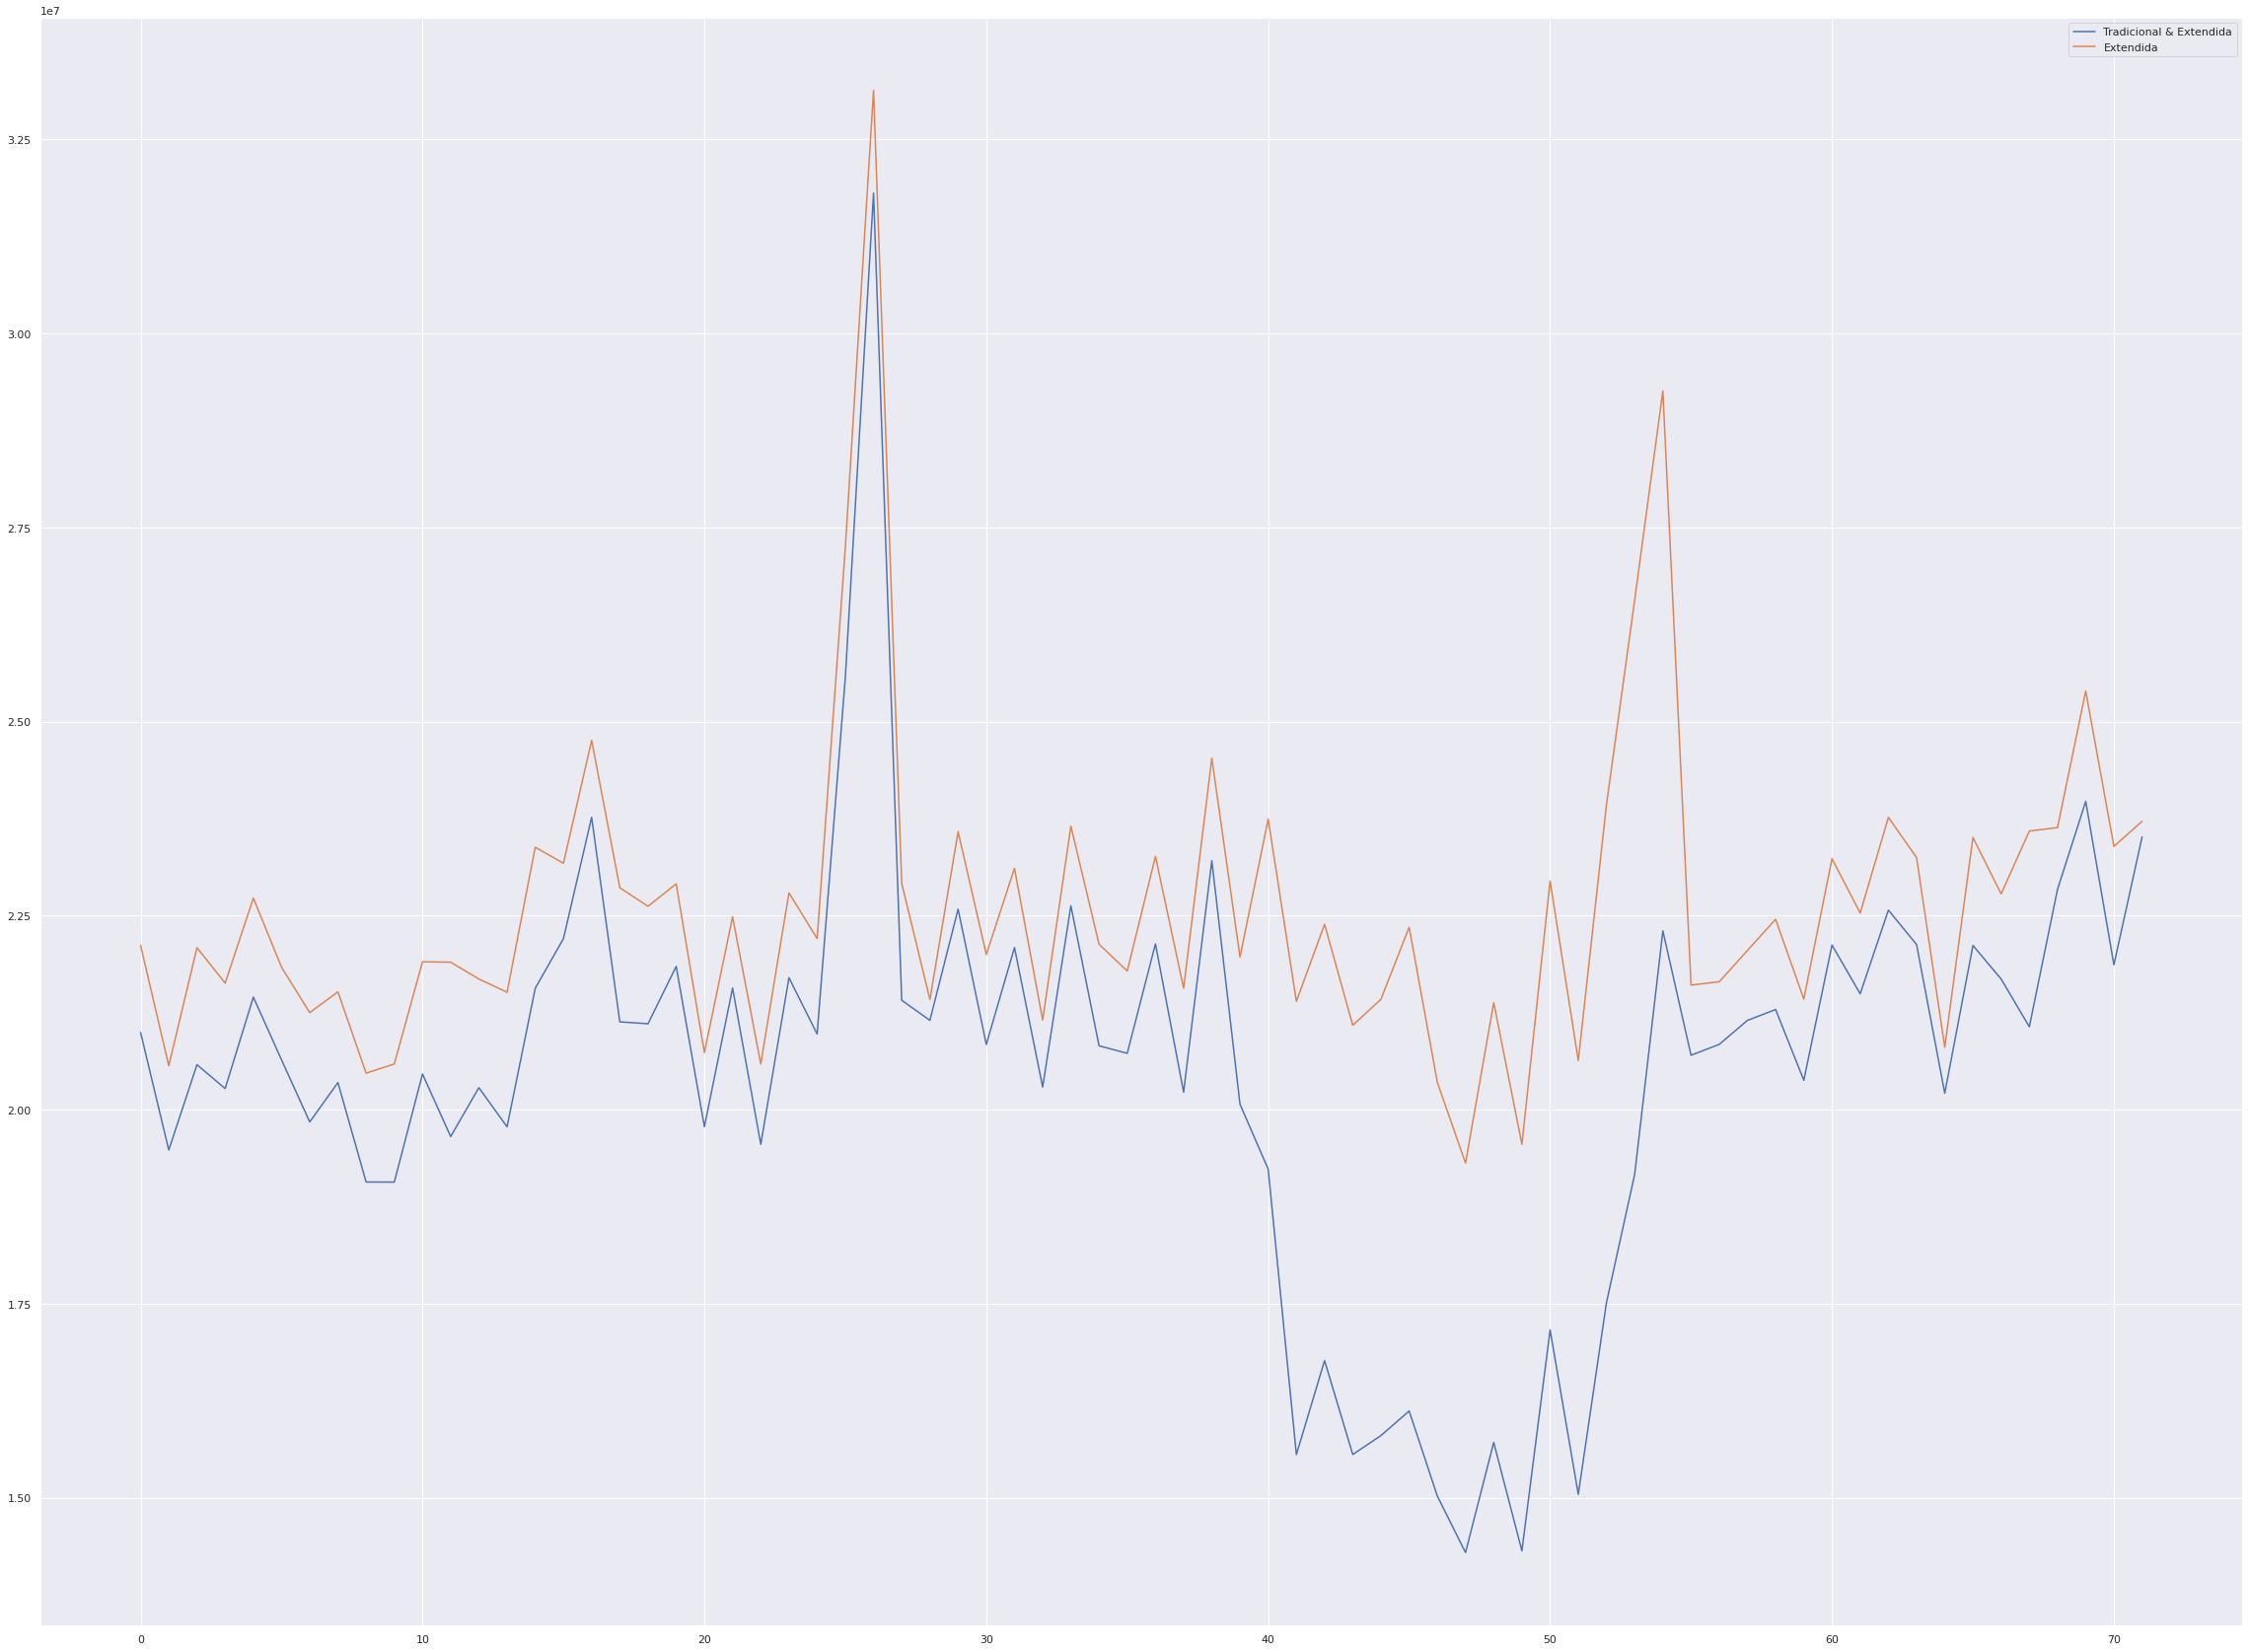

In [46]:
aux1= df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax= aux1.plot()

aux1= df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H7 Lojas aberta durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas aberta durante o feriado do natal vendem menos.

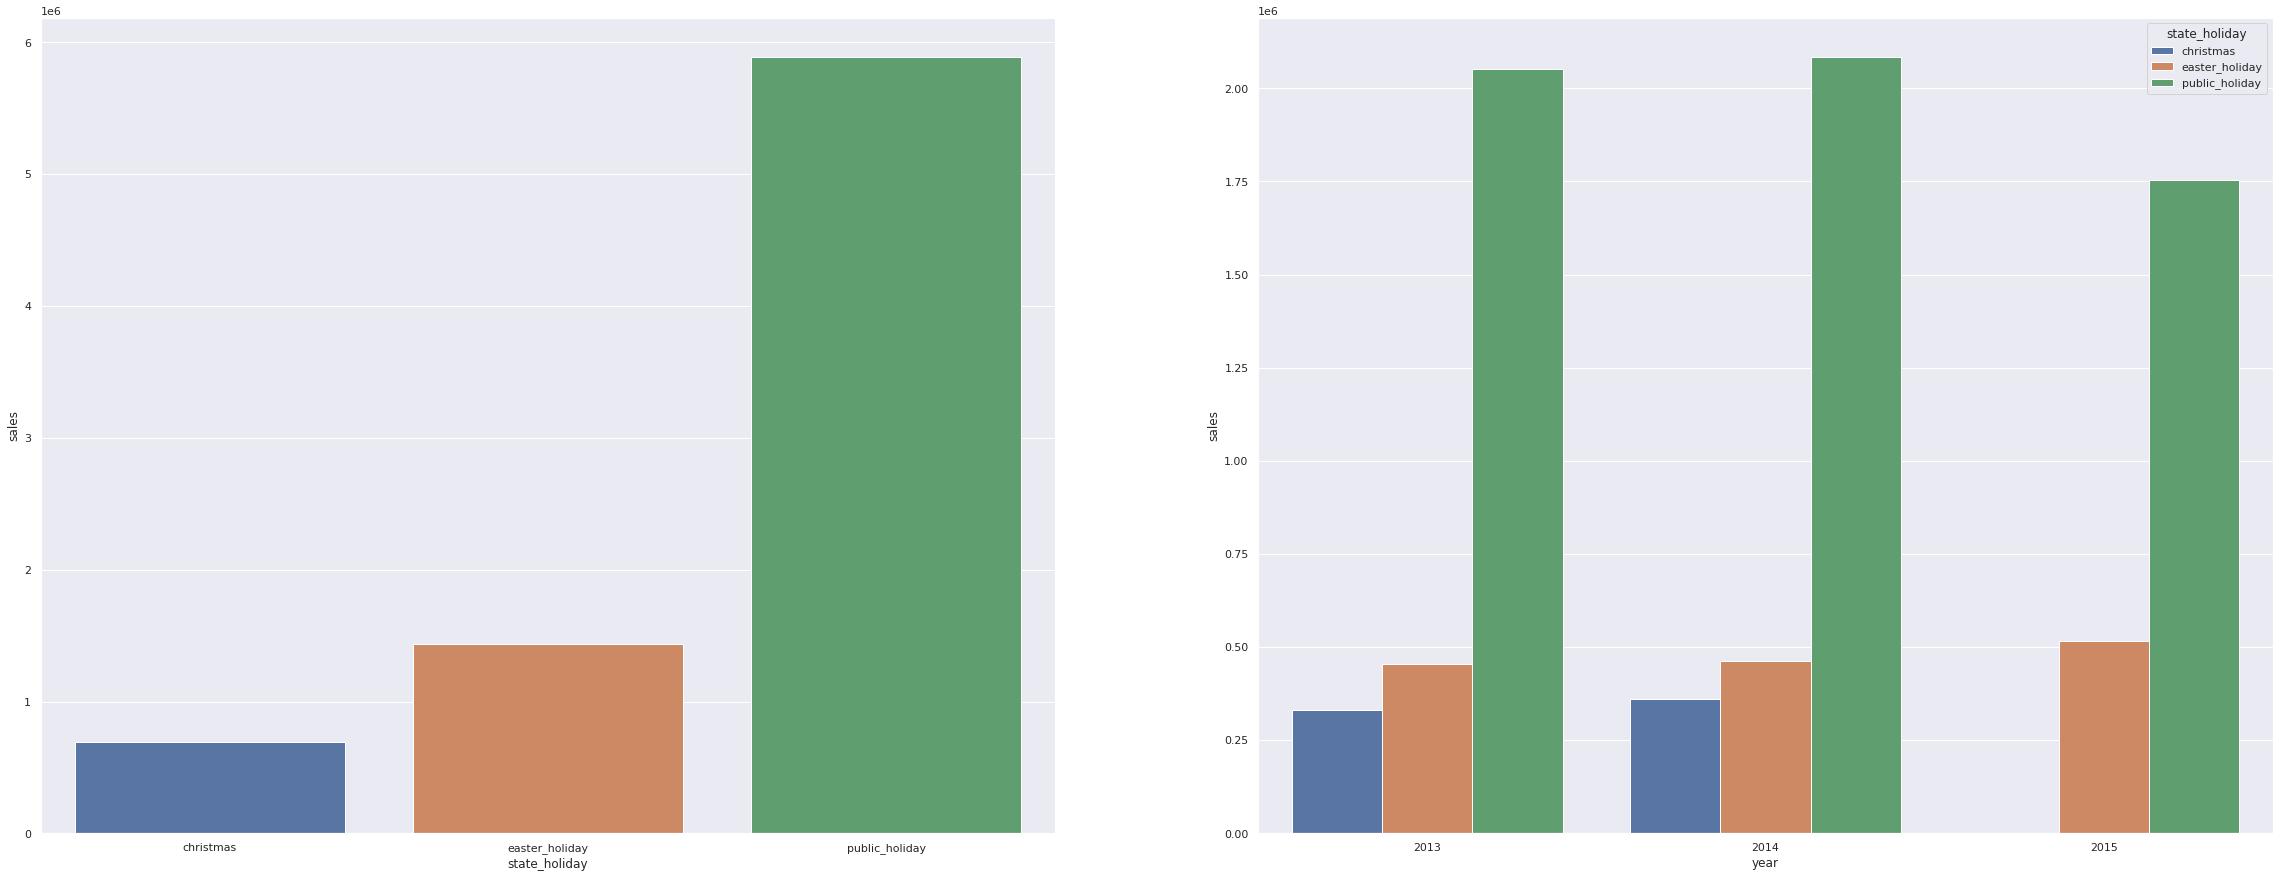

In [47]:

aux= df4[df4['state_holiday'] != 'regular_day']
aux1= aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

sns.set(rc = {'figure.figsize':(40,15)})

plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2= aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x= 'year', y='sales', hue='state_holiday', data=aux2);

### H8 Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos.

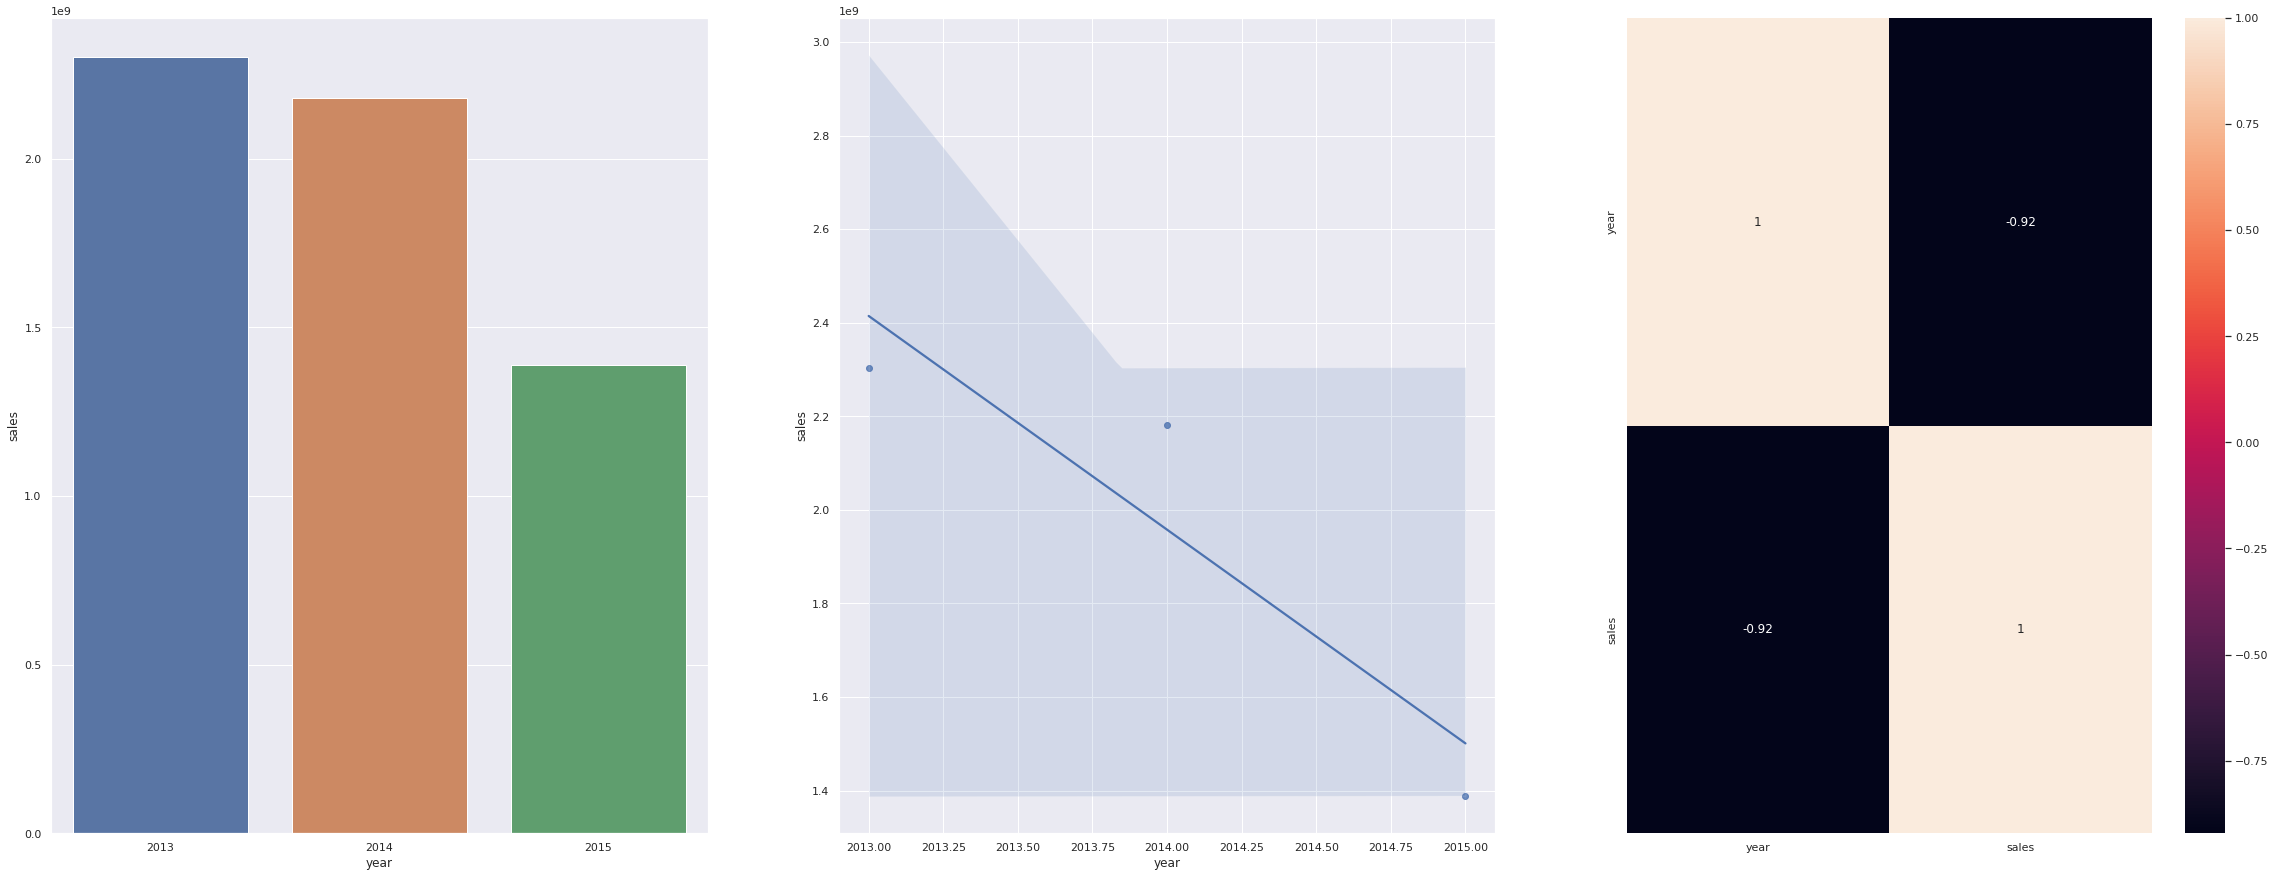

In [48]:
aux1= df4[['year', 'sales']].groupby('year').sum().reset_index()

sns.set(rc = {'figure.figsize':(40,15)})

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);



### H9 Lojas deveriam vender mais no segundo semetre do ano.
**FALSA** Lojas vendem menos no segundo semestre do anos.

<AxesSubplot:>

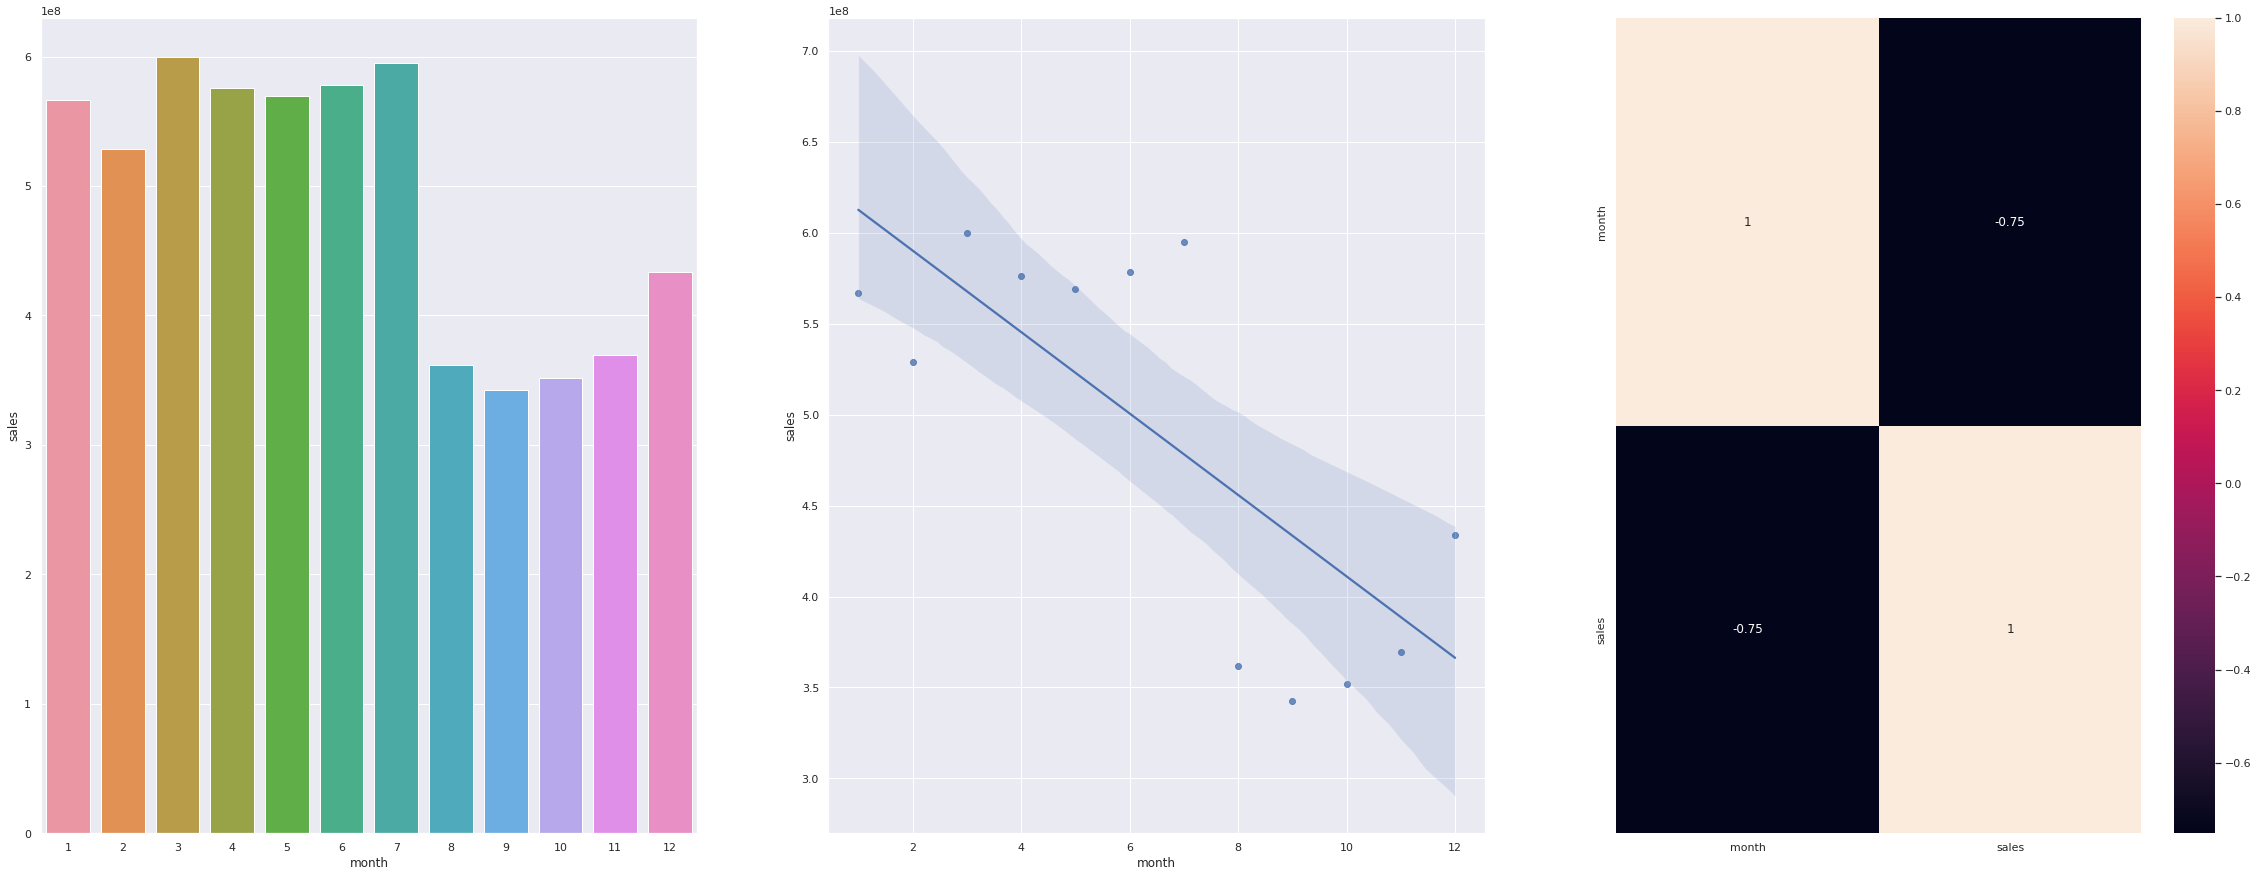

In [49]:
aux1= df4[['month', 'sales']].groupby('month').sum().reset_index()

sns.set(rc = {'figure.figsize':(40,15)})

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H10 Lojas deveriam vender mais depois do dia 10 de cada mes.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

In [50]:
aux1['before_after'] = df4.apply(lambda x: 'before_10_days' if x.day <= 10 else 'after_10_days', axis=1)
aux1.head()

,month,sales,before_after
0,1,566728724,after_10_days
1,2,528734410,after_10_days
2,3,599831906,after_10_days
3,4,575895295,after_10_days
4,5,569248217,after_10_days


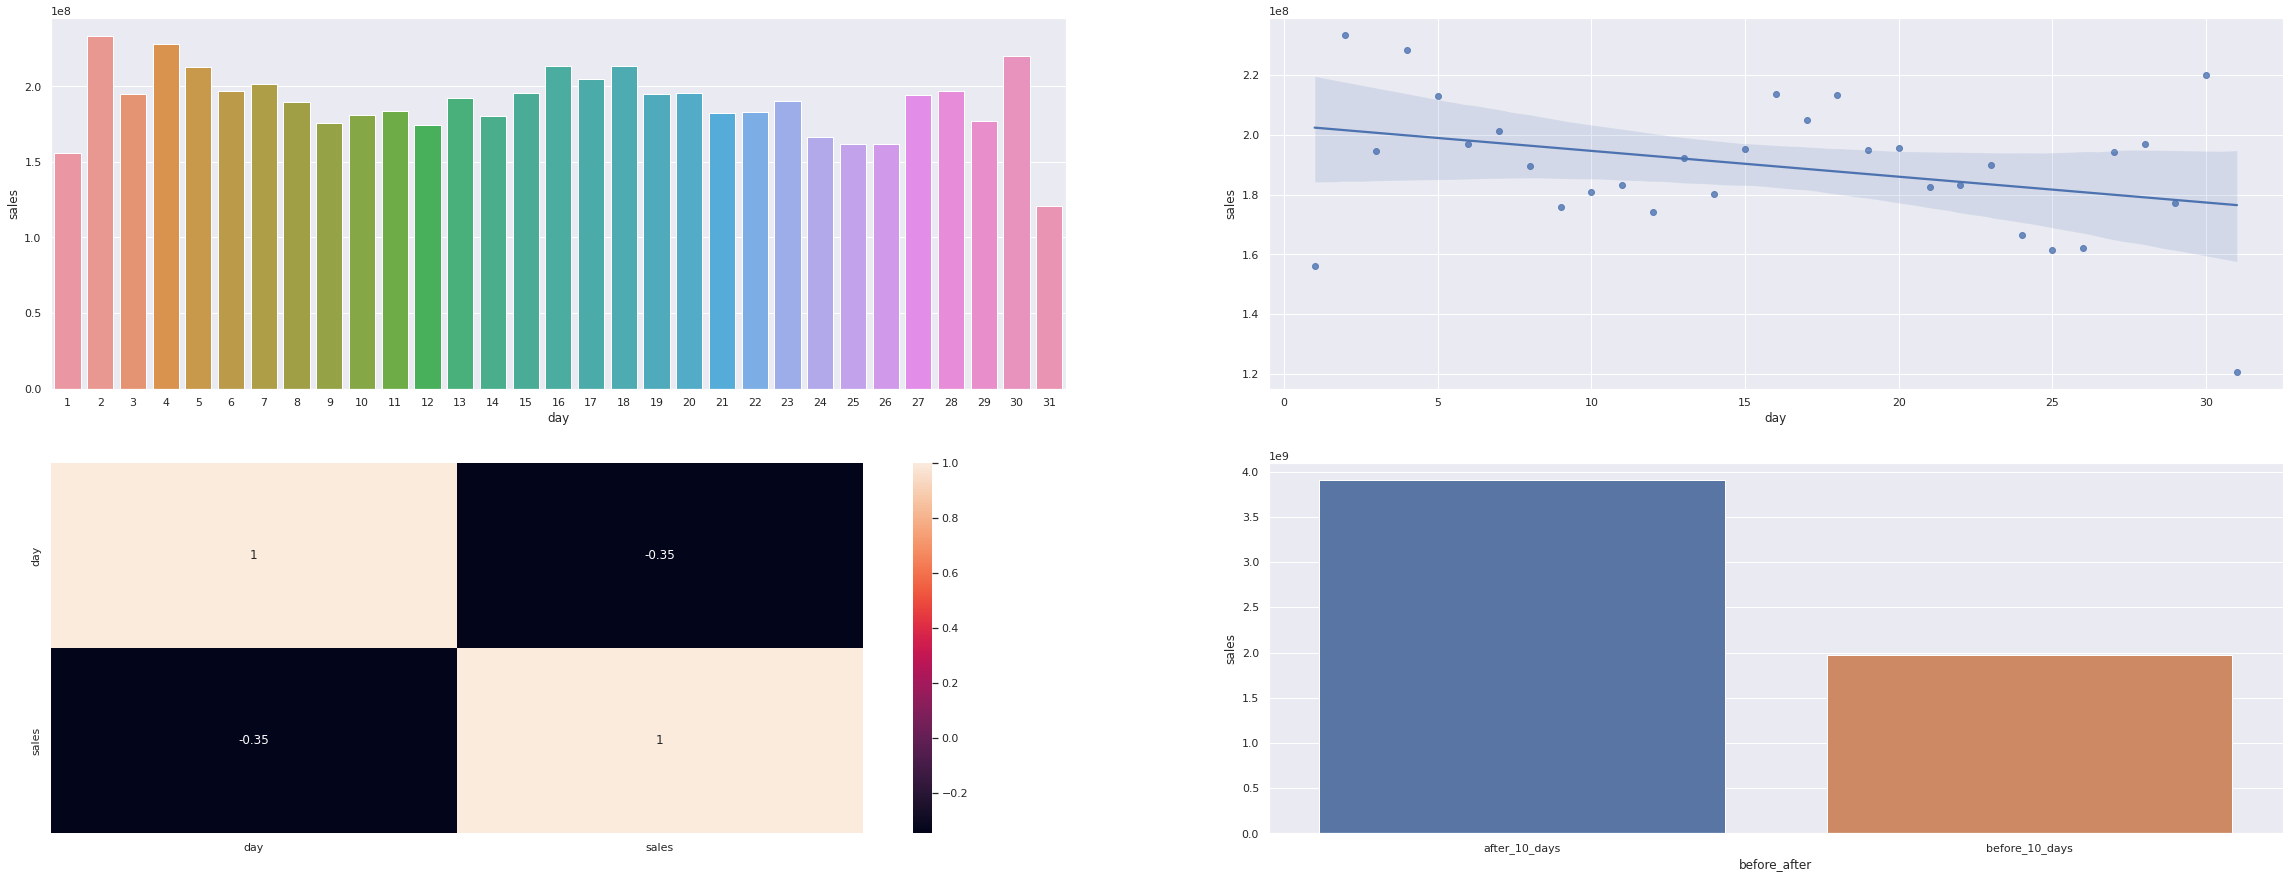

In [51]:
aux1= df4[['day', 'sales']].groupby('day').sum().reset_index()

sns.set(rc = {'figure.figsize':(40,15)})

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2= aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);


### H11 Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos aos finals de semana 

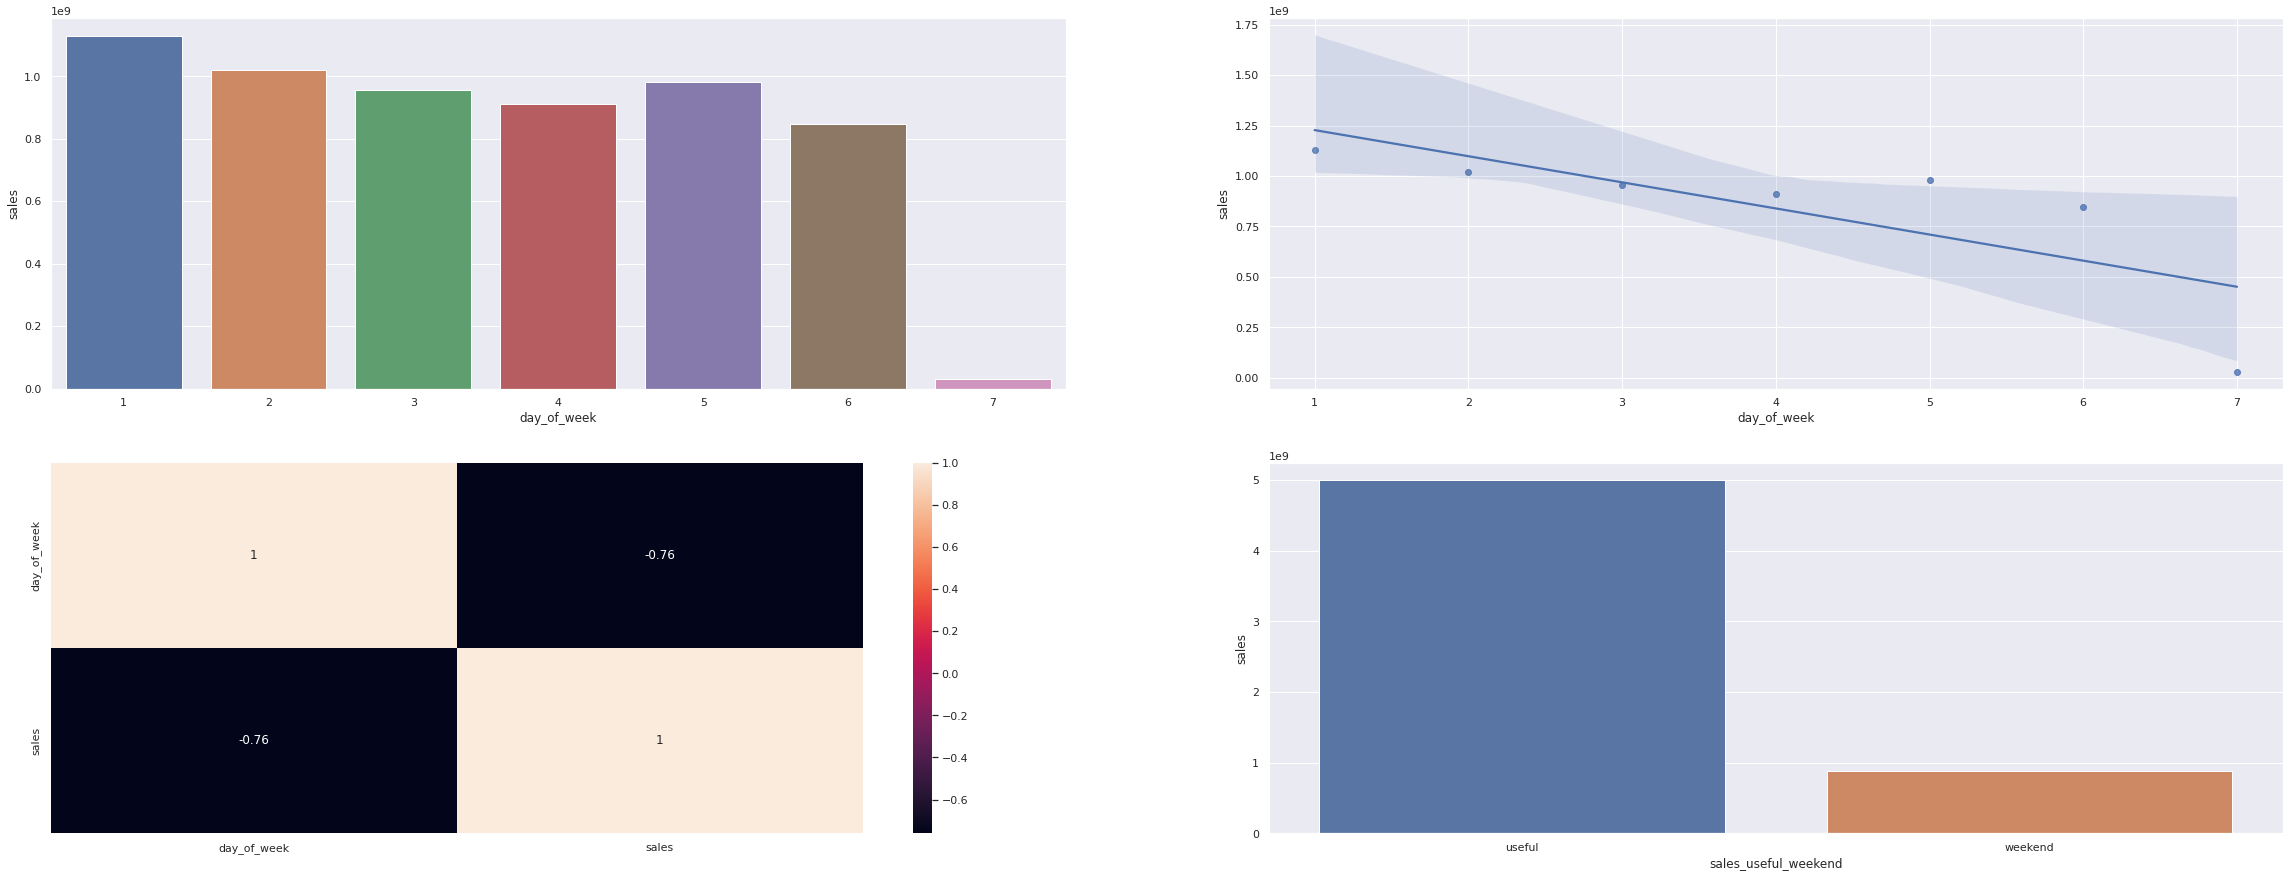

In [52]:
aux1= df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

sns.set(rc = {'figure.figsize':(40,15)})

plt.subplot(2,2,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['sales_useful_weekend'] = aux1['day_of_week'].apply(lambda x: 'useful' if x <= 5 else 'weekend')
aux2= aux1[['sales_useful_weekend', 'sales']].groupby('sales_useful_weekend').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='sales_useful_weekend', y='sales', data=aux2);


### H13 Lojas deveria vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolar no geral, exceto para o mes de agosto.

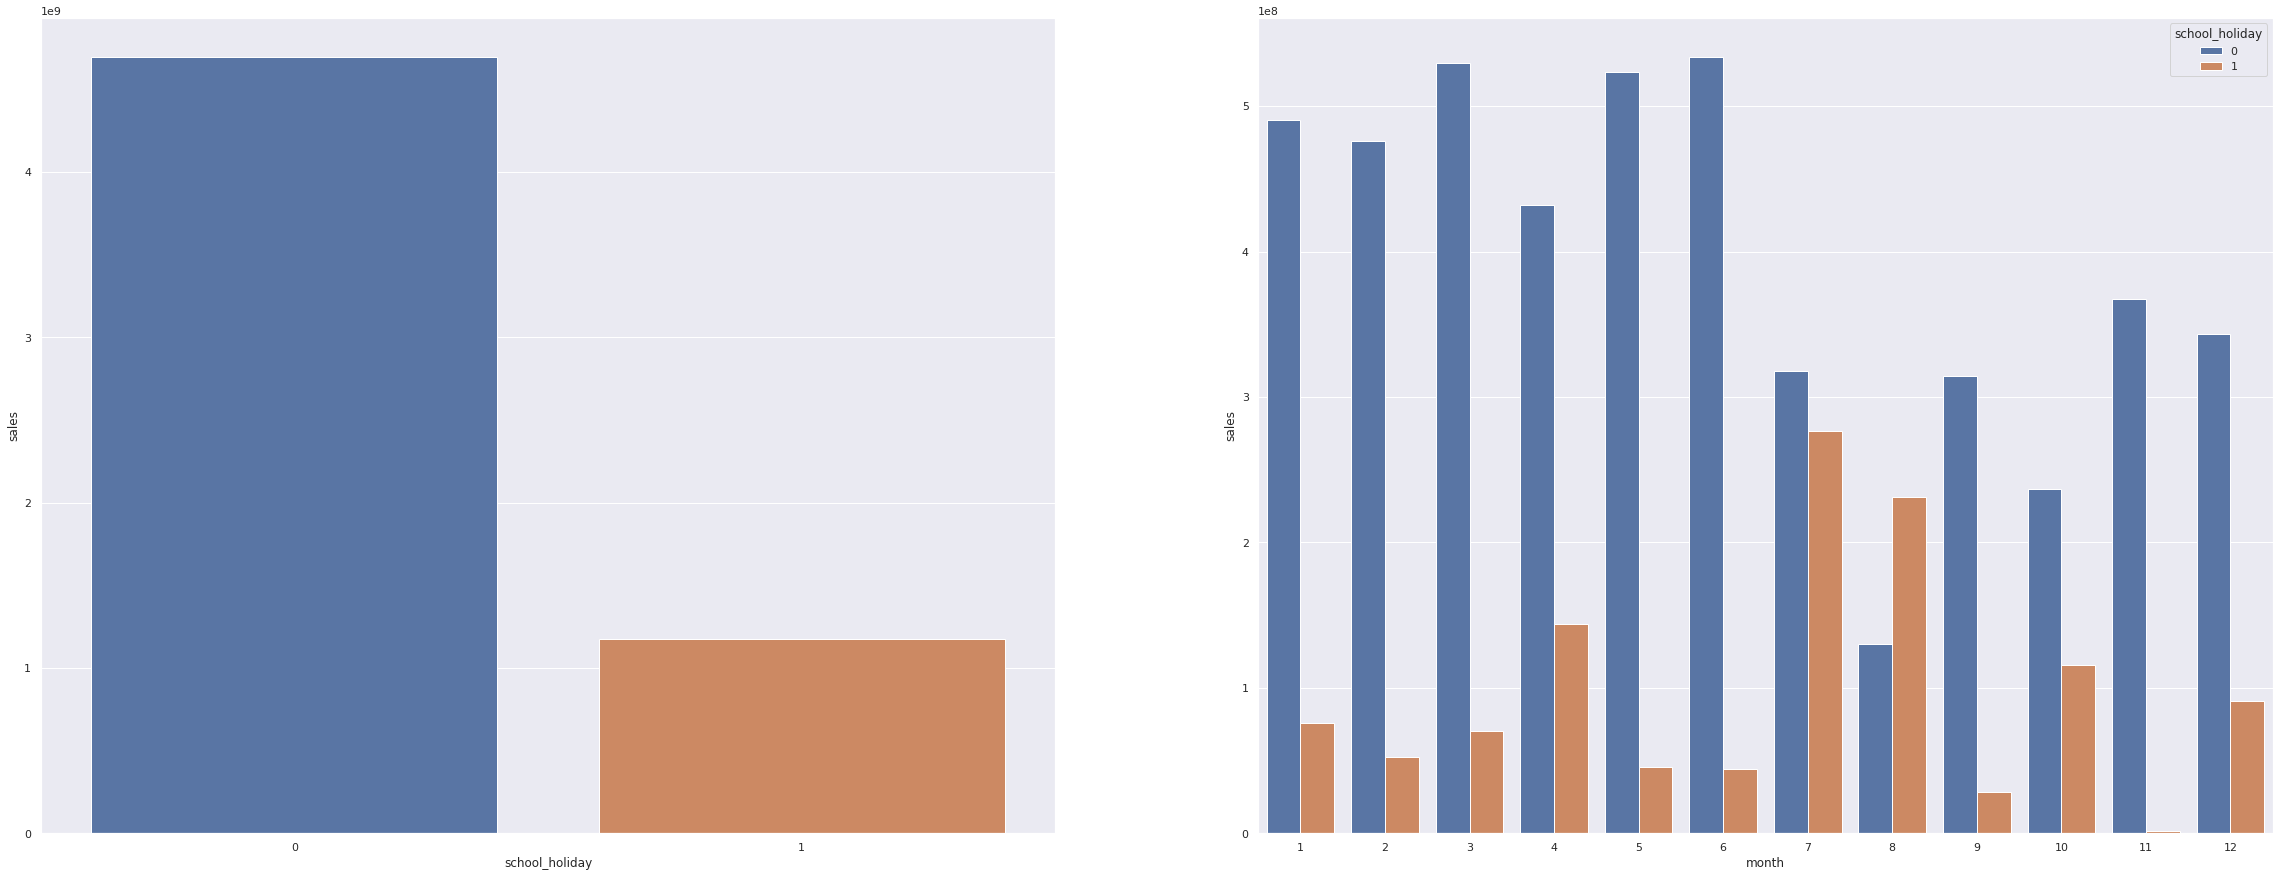

In [53]:
sns.set(rc = {'figure.figsize':(40,15)})

plt.subplot(1,2,1)
aux1= df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2= df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2);

### Resumo das Hipoteses

In [54]:
from tabulate import tabulate

In [55]:
tab = [
    ['Hipoteses', 'Conclusão', 'Relevancoa'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H6', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Media'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Baixa'],
]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevancoa
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## Analise Multivariada

- Analise Multivariada ajuda a olhar as variaveis correlacionadas e portando podem ser retiradas, para diminuir a dimensionalidade do dataset, e assim diminuir a complexidade do modelo

### Numerical Attribute

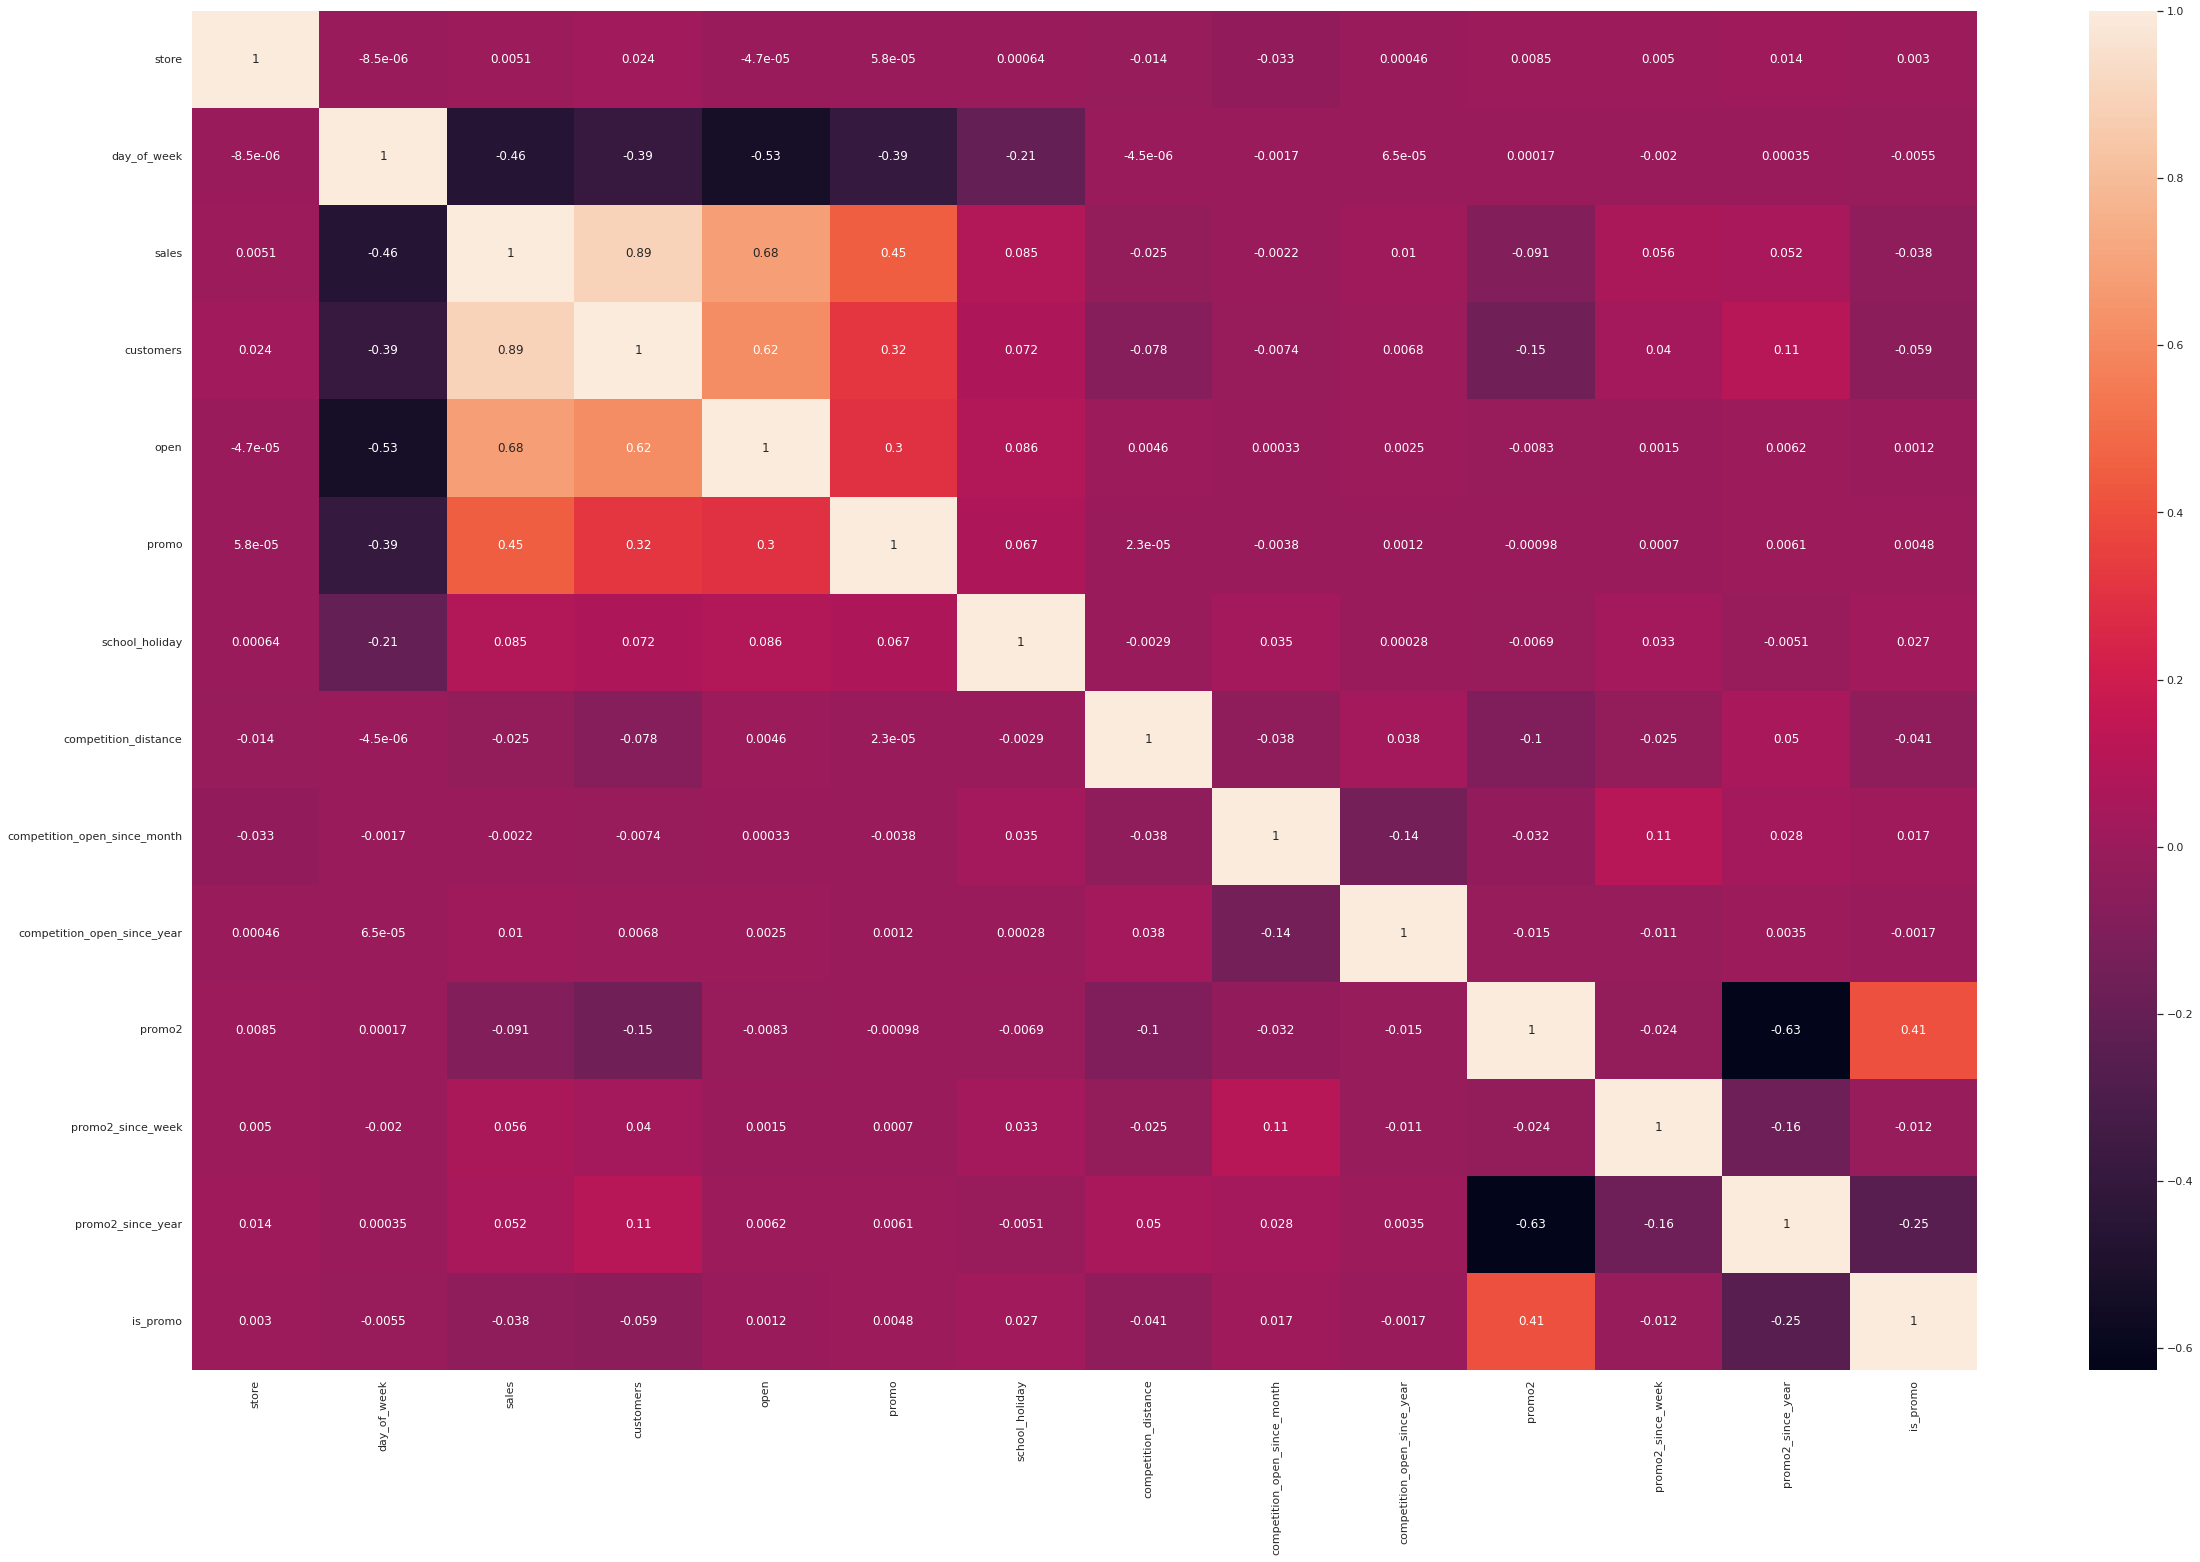

In [56]:
correlation= num_atributes.corr(method='pearson')

sns.set(rc = {'figure.figsize':(40,25)})

sns.heatmap(correlation, annot=True);

### Categorical Attributes

In [57]:
categorical = df4.select_dtypes(include='object')

In [58]:
cm = pd.crosstab(categorical['state_holiday'], categorical['store_type']).values

In [59]:
#Calculo cramer v

a1= cramer_v(categorical['state_holiday'], categorical['state_holiday'])
a2= cramer_v(categorical['state_holiday'], categorical['store_type'])
a3= cramer_v(categorical['state_holiday'], categorical['assortment'])

a4= cramer_v(categorical['store_type'], categorical['state_holiday'])
a5= cramer_v(categorical['store_type'], categorical['store_type'])
a6= cramer_v(categorical['store_type'], categorical['assortment'])

a7= cramer_v(categorical['assortment'], categorical['state_holiday'])
a8= cramer_v(categorical['assortment'], categorical['store_type'])
a9= cramer_v(categorical['assortment'], categorical['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
            'store_type': [a4, a5, a6],
             'assortiment': [a7, a8, a9]})
d= d.set_index(d.columns)

<AxesSubplot:>

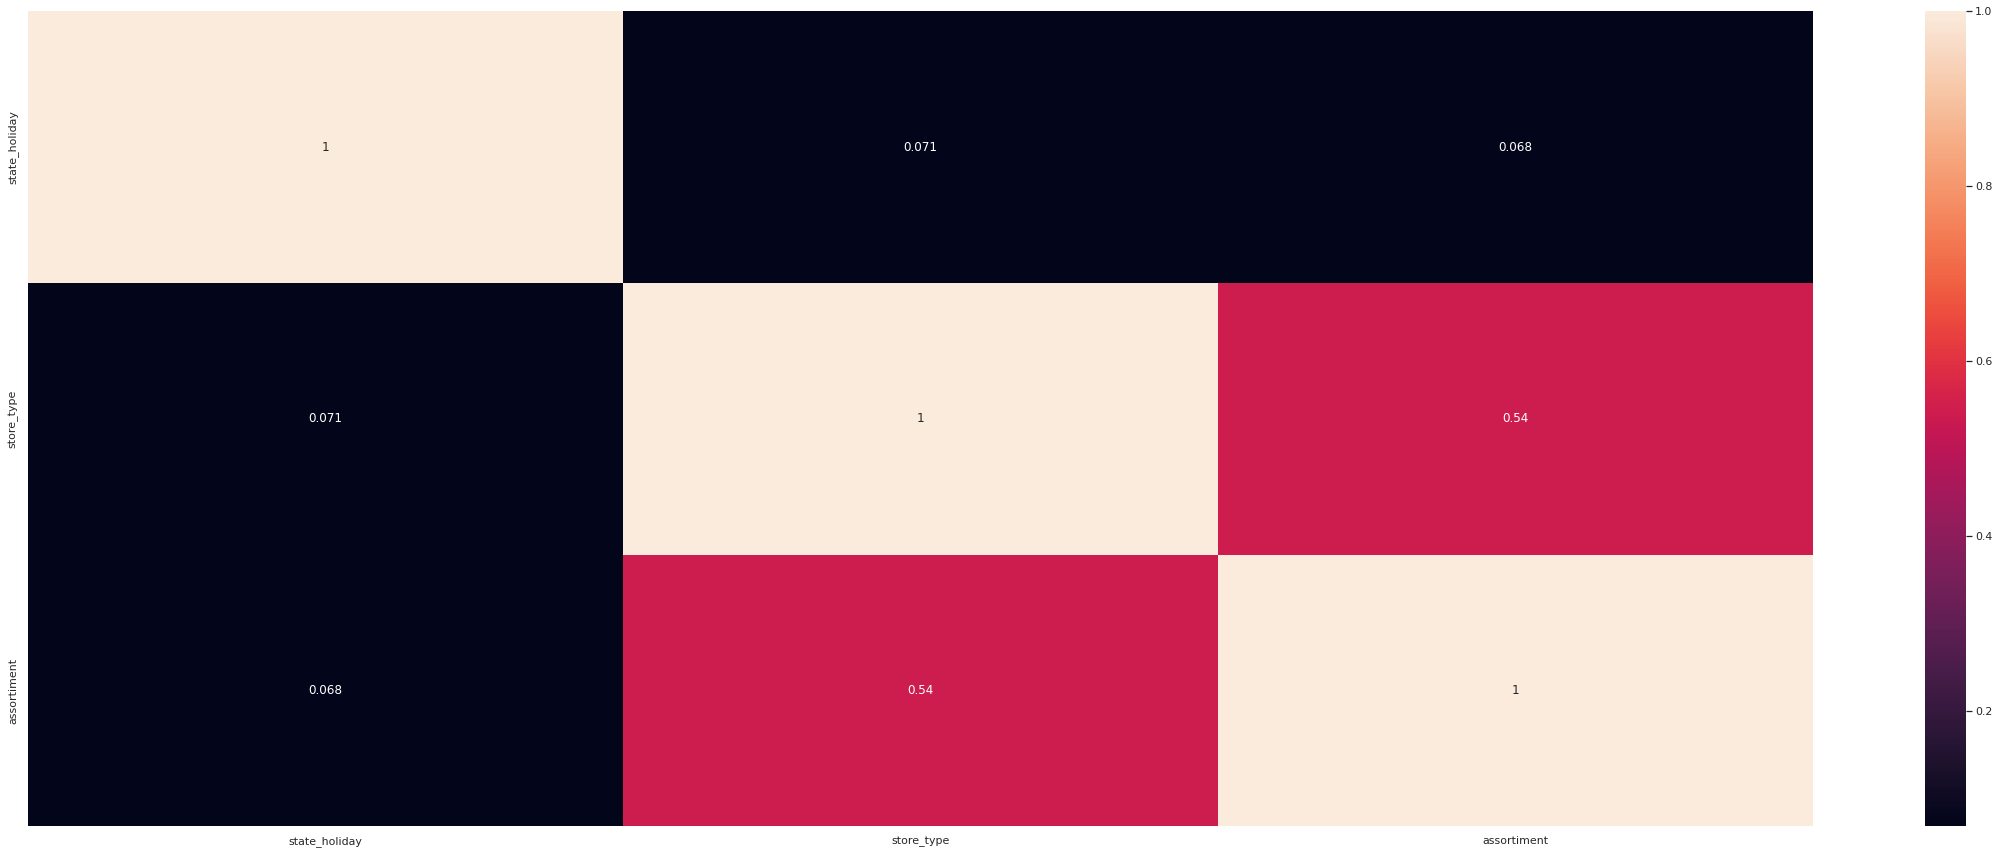

In [60]:
sns.set(rc = {'figure.figsize':(40,15)})
sns.heatmap(d, annot=True)

# 5 - Data Preparation

In [61]:
df5 = df4.copy()

In [62]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## Normalização

In [63]:
#Não temos nenhuma variavel com a distribuição normal, neste caso não usaremos a tecnica de normalização

## Rescaling

In [64]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [65]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [66]:
rs= RobustScaler()
mms= MinMaxScaler()

# competition_distance

df5['competition_distance']= rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month']= rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week']= mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year']= mms.fit_transform(df5[['year']].values)

#### Salvando as transformações Modulo 10 Deploy model to Production##################################

pickle.dump(rs, open ('parameter/competition_distance_scaler.pkl', 'wb'))
pickle.dump(rs, open ('parameter/competition_time_month_scaler.pkl', 'wb'))
pickle.dump(mms, open ('parameter/promo_time_week_scaler.pkl', 'wb'))
pickle.dump(mms, open ('parameter/year_scaler.pkl', 'wb'))

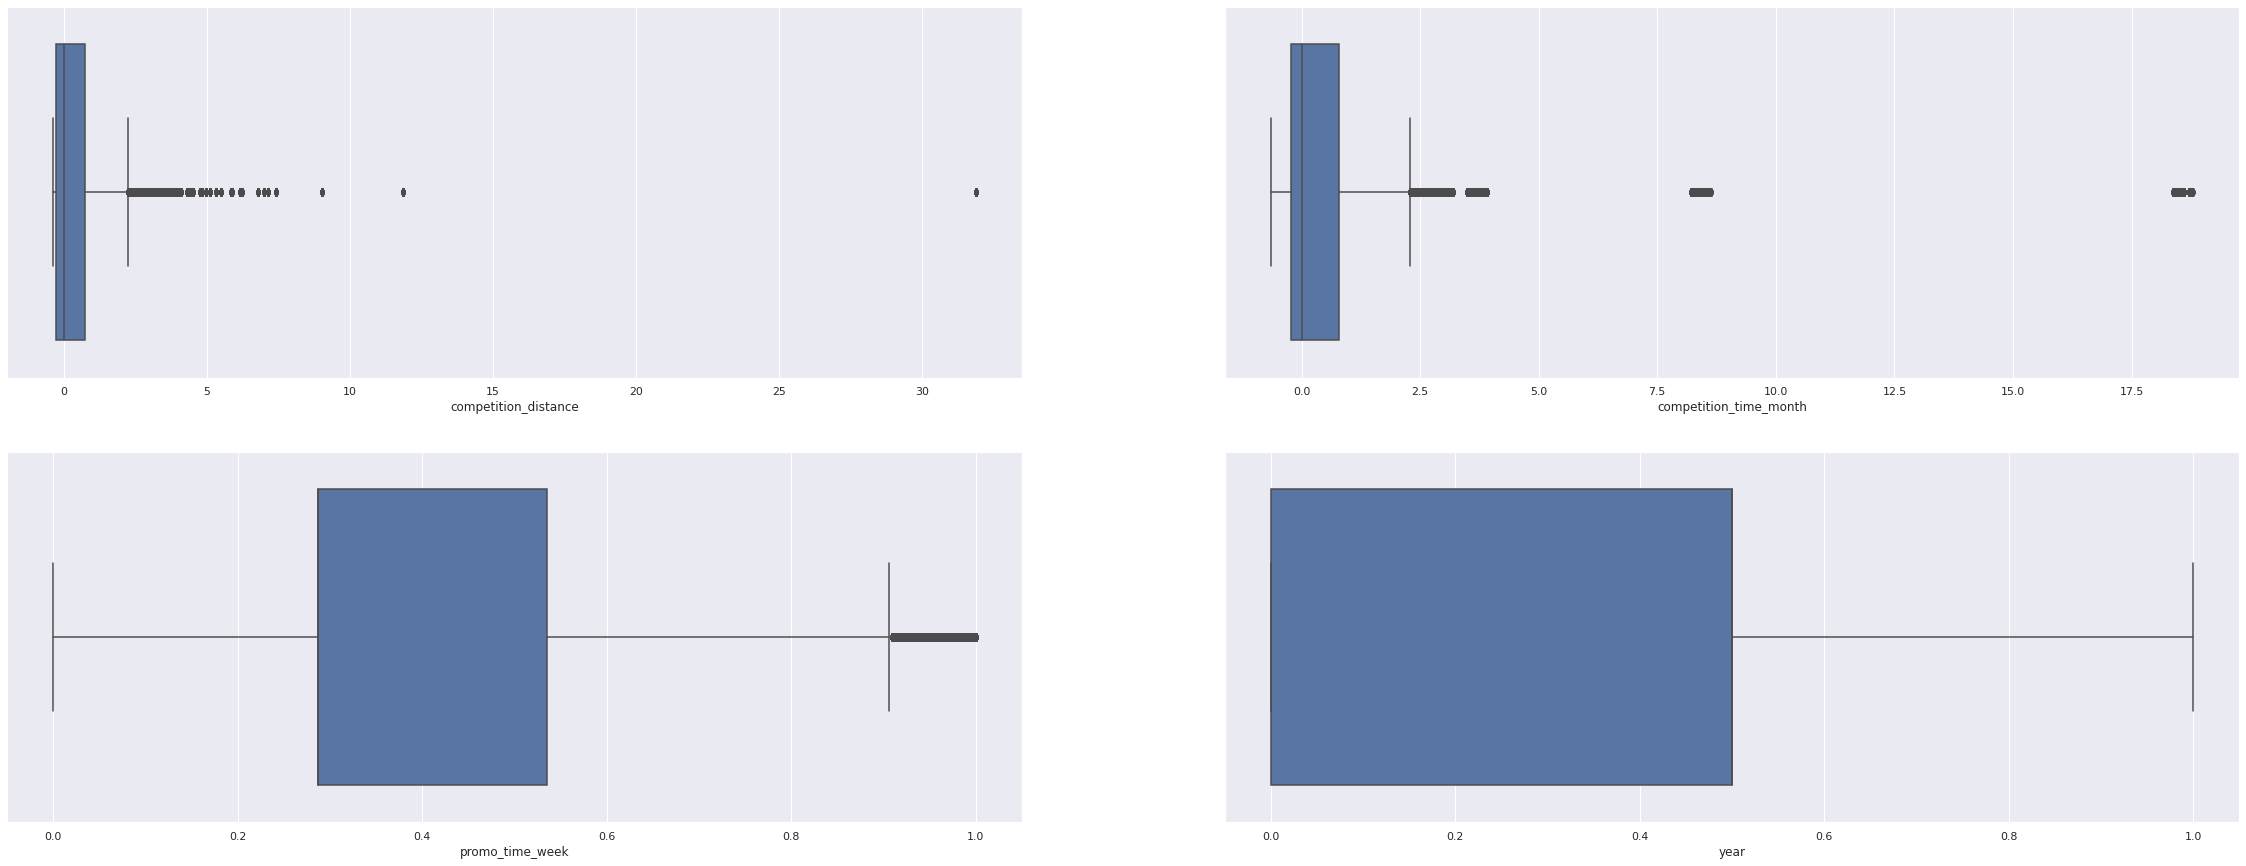

In [67]:
sns.set(rc = {'figure.figsize':(40,15)})

plt.subplot(2, 2,1)
sns.boxplot(df5['competition_distance'])

plt.subplot(2, 2,2)
sns.boxplot(df5['competition_time_month'])

plt.subplot(2, 2,3)
sns.boxplot(df5['promo_time_week'])

plt.subplot(2, 2,4)
sns.boxplot(df5['year']);

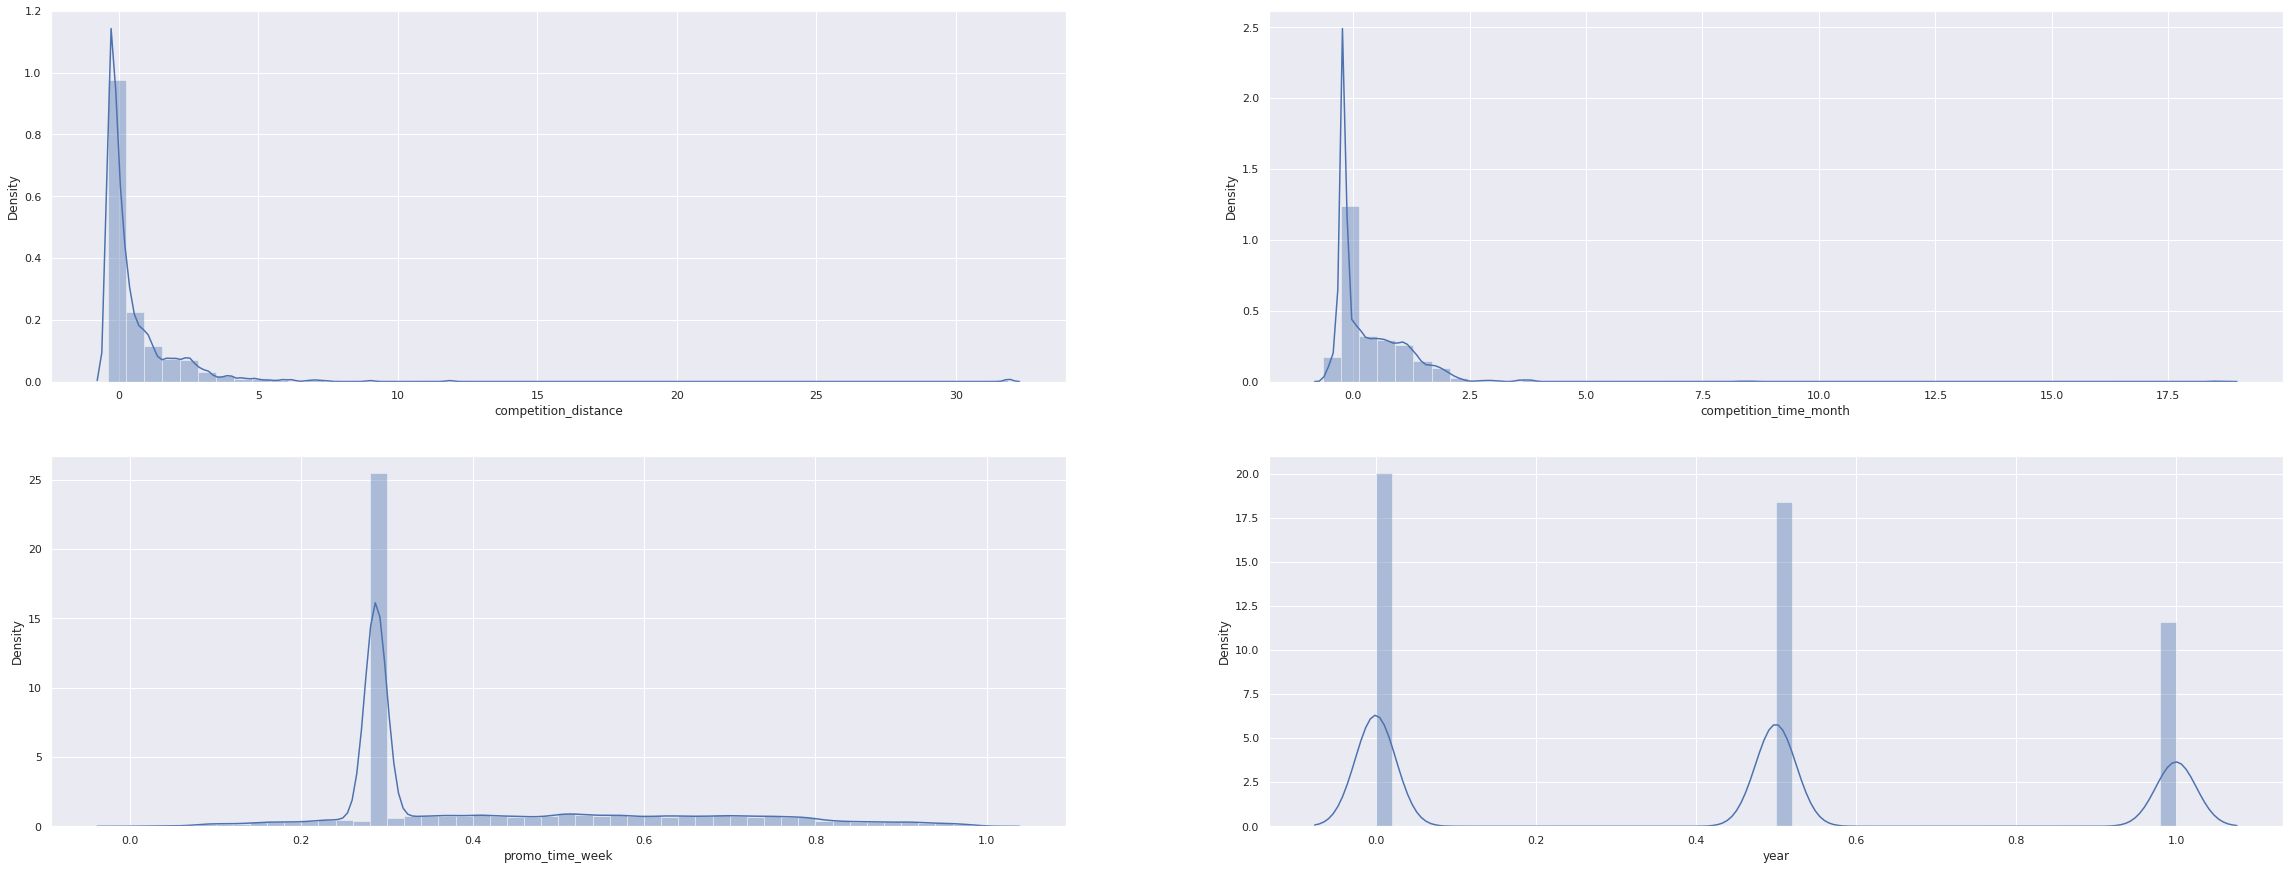

In [68]:
sns.set(rc = {'figure.figsize':(40,15)})

plt.subplot(2, 2,1)
sns.distplot(df5['competition_distance'])

plt.subplot(2, 2,2)
sns.distplot(df5['competition_time_month'])

plt.subplot(2, 2,3)
sns.distplot(df5['promo_time_week'])

plt.subplot(2, 2,4)
sns.distplot(df5['year']);

## Transformação

### Enconding

In [69]:
# state_holiday (Variaveis de momentos) - One Hot Enconding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'] )

le= LabelEncoder()
# store_type (Não existe uma ordem) - Label Encoding
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment (Existe uma ordem nesta variavel) - Ordinal Enconding
assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### Salvando as transformações Modulo 10 Deploy model to Production##################################

# Get dummies da para criar direto na produção

pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment é um dicionario, tambem da para criar na produção


### Response Variable Transformation

In [70]:
df5['sales'] = np.log1p(df5['sales'])

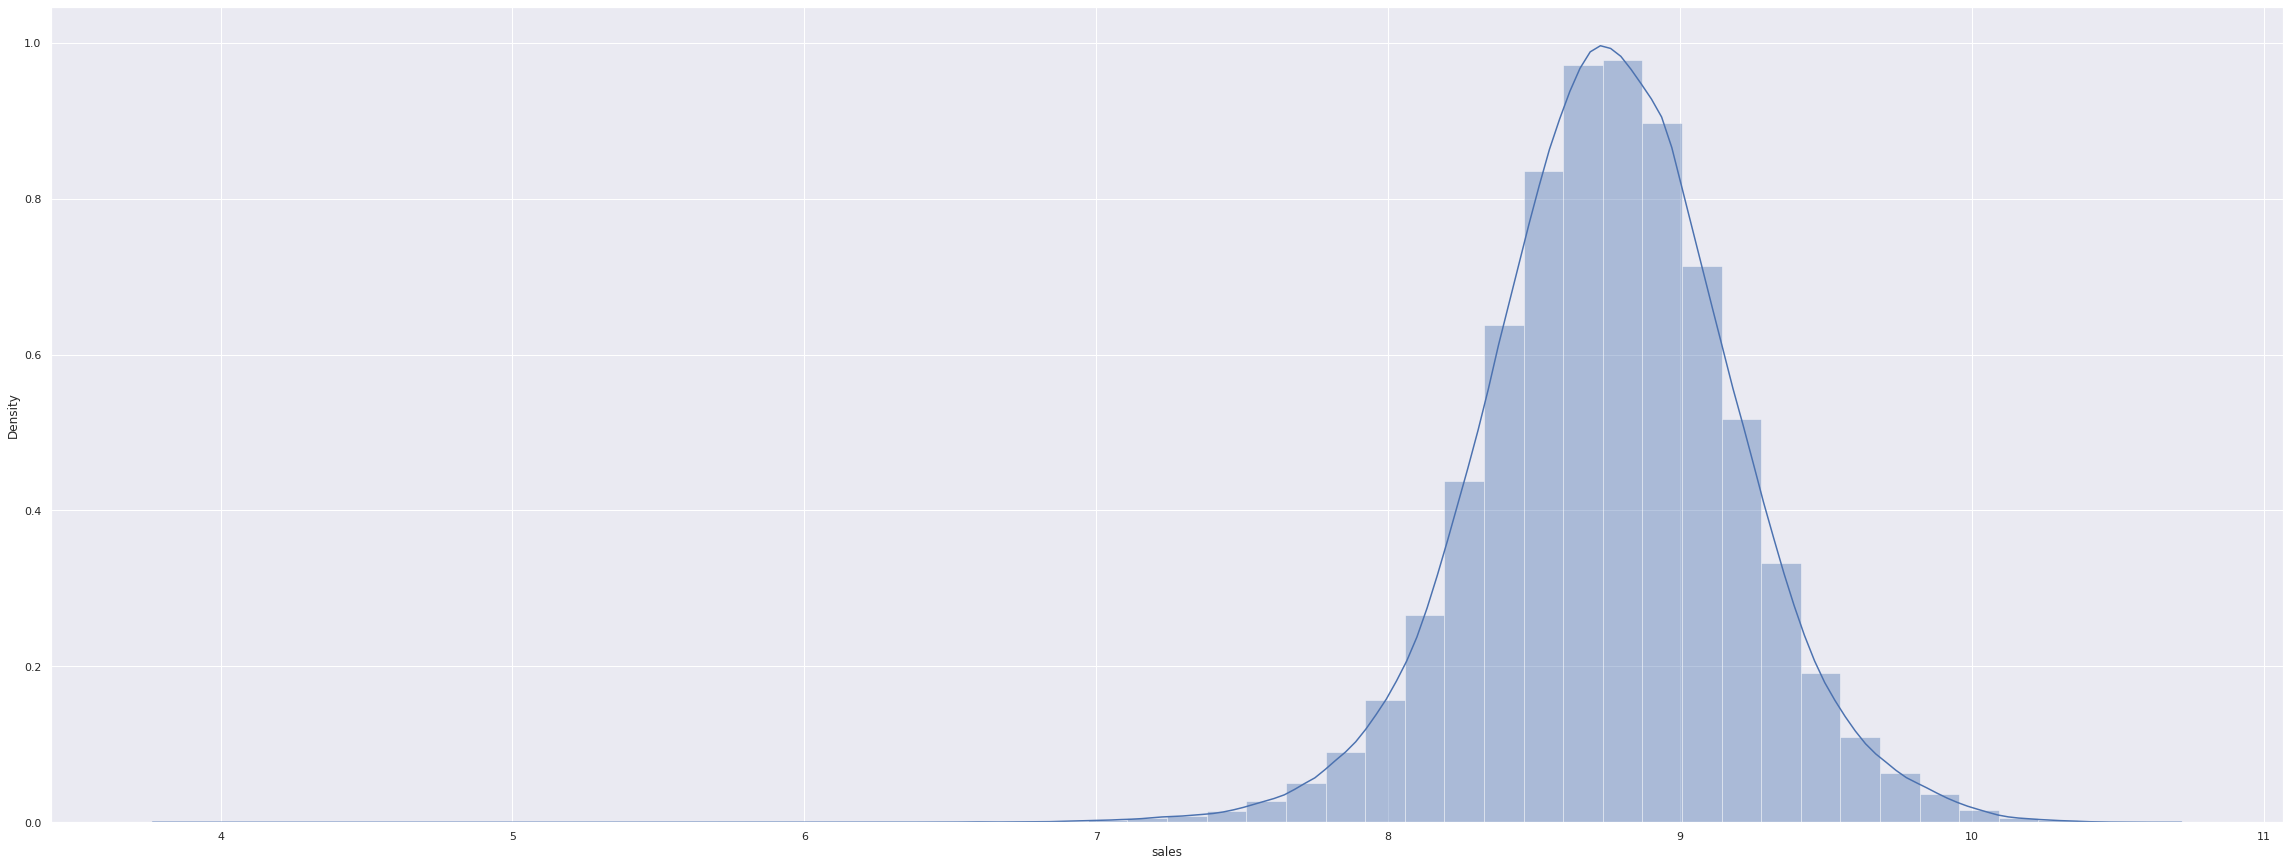

In [71]:
sns.set(rc = {'figure.figsize':(40,15)})

sns.distplot(df5['sales']);

### Nature Transformation

In [72]:
#Citrus Variables (Sine and cosine calculation)

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

In [73]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6 - Features Selection

In [74]:
df6 = df5.copy()

#df6.to_csv('feature_select_test.csv', index=False)

## Split dataframe into training and test dataset

In [75]:
#excluding columns
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [76]:
#Separating training and test data

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print("Training Min Date: {}".format(X_train['date'].min()))
print("Training Max Date: {}".format(X_train['date'].max()))

print("\nTest Min Date: {}".format(X_test['date'].min()))
print("Test Max Date: {}".format(X_test['date'].max()))

print ('\n{}'.format(X_train.shape, y_train.shape))
print ('{}'.format(y_train.shape))

print ('\n{}'.format(X_test.shape, y_train.shape))
print ('{}'.format(y_test.shape))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00

(802942, 29)
(802942,)

(41396, 29)
(41396,)


## Boruta as Features Selector

In [77]:
#Training and test dataset for Boruta (Does not accept dataframe, turn into numpy)

#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()


#Define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#Define Boruta


#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

## Beast Features From Boruta 

In [78]:
#cols_selected= boruta.support_.tolist()

#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list() #Features selecionada pelo modelo

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))#Features que o Boruta rejeitor

## Manual Feature Selection

- Columns relevant to the model


In [79]:
col_selected_boruta =[ 
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

#Columns to add
feat_to_add = ['date', 'sales']

#Criação de uma variavel para criação do cross validation
cols_selected_boruta_full = col_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7 - Machine Learning Modelling

In [80]:
x_train = X_train[col_selected_boruta]
x_test = X_test[col_selected_boruta]

## Average Model

In [81]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

aux2= aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})

aux1=pd.merge(aux1, aux2, on='store', how='left')

yhat_baseline = aux1['predictions']

#Performance

baseline_result = ml_error('Average model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result
#Função np.exmp1 devolve o valor real da coluna, pois o mesmo em alguma seção anterior foi transformado em Log 

,Model Name,MAE,MAPE,RMSE,R
0,Average model,1354.800353,0.2064,1835.135542,0.636551


## Linear Regression Model

In [82]:
#model

lr = LinearRegression().fit(x_train, y_train)

#Prediction
yhat_lr = lr.predict(x_test)

#Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE,R
0,Linear Regression,1867.089774,0.292694,2671.049215,0.230035


## Linear Regression Regularized Model - Lasso

In [83]:
#model

lrr = Lasso(alpha=0.0001).fit(x_train, y_train)

#Prediction
yhat_lrr = lrr.predict(x_test)

#Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE,R
0,Linear Regression - Lasso,1867.907526,0.291894,2675.988566,0.227185


## Random Forest Regressor

In [84]:
#model

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#Prediction
yhat_rf = rf.predict(x_test)

#Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE,R
0,Random Forest Regressor,679.391484,0.099888,1010.731125,0.88975


## XGBoost Regressor

In [85]:
#model

model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=100,
                                eta=0.01,
                                max_depth=15,
                                subsample=0.7,
                                colsample_bytee=0.9 ).fit(x_train, y_train)

#Prediction
yhat_xgb = model_xgb.predict(x_test)

#Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[14:51:34] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE,R
0,XGBoost Regressor,6682.827533,0.949909,7327.177998,-4.79403


## Compare Model's Performance

In [86]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE,R
0,Random Forest Regressor,679.391484,0.099888,1010.731125,0.889750
0,Average model,1354.800353,0.206400,1835.135542,0.636551
0,Linear Regression,1867.089774,0.292694,2671.049215,0.230035
0,Linear Regression - Lasso,1867.907526,0.291894,2675.988566,0.227185
0,XGBoost Regressor,6682.827533,0.949909,7327.177998,-4.794030


## Cross Validation

In [87]:
x_train = X_train[col_selected_boruta]
x_test = X_test[col_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

### Linear Regression Model

In [88]:
model = LinearRegression()

linear_regressor = cross_validation(x_training, 5, 'Linear Regression', model)
linear_regressor

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### Linear Regression Regularized Model - Lasso

In [89]:
lasso = Lasso(alpha=0.0001).fit(x_train, y_train)

linear_regression_lasso = cross_validation(x_training, 5, 'Linear Regression - Lasso', lasso)
linear_regression_lasso

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2081.64 +/- 298.77,0.3 +/- 0.02,2955.91 +/- 471.18


### Random Forest Regressor

In [90]:
model_forest = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

random_forest = cross_validation(x_training, 5, 'Random Forest Regressor', model_forest)
random_forest

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.69 +/- 218.47,0.12 +/- 0.02,1256.39 +/- 319.05


### XGBoost Regressor

In [91]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=100,
                                eta=0.01,
                                max_depth=10,
                                subsample=0.7,
                                colsample_bytee=0.9 )

xgboost = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)

[14:59:37] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:59:54] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:00:14] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually 

In [92]:
xgboost

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.94 +/- 587.59,0.95 +/- 0.0,7714.01 +/- 688.65


### Compare Model's Performance Cross Validation'

In [93]:
modelling_result_cv = pd.concat([linear_regressor, linear_regression_lasso, random_forest, xgboost])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.69 +/- 218.47,0.12 +/- 0.02,1256.39 +/- 319.05
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression - Lasso,2081.64 +/- 298.77,0.3 +/- 0.02,2955.91 +/- 471.18
0,XGBoost Regressor,7047.94 +/- 587.59,0.95 +/- 0.0,7714.01 +/- 688.65


# 8 - Hyperparameter Fine Tuning

3 fine tuning strategies (Find the best parameter for the model)
- Random Search
- Grid Search
- Bayesian Search

## Random Search

In [94]:
#import random

#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#    }

#MAX_EVAL = 10


#final_resort = pd.DataFrame()

#for i in range( MAX_EVAL):


#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items()}
#    print(hp)

    #model

#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                            n_estimators=hp['n_estimators'],
#                            eta= hp['eta'],
#                            max_depth= hp['max_depth'],
#                            subsample= hp['subsample'],
#                            colsample_bytree= hp['colsample_bytree'],
#                            min_child_weight = hp['min_child_weight'])

  

    #Performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
#    final_resort = pd.concat([final_resort, result])
#    final_resort

#runtime 153m 40s

## Fine Model

In [95]:
param_tuned = {
    'n_estimators':1500 ,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.1,
    'colsample_bytee': 0.7,
    'min_child_weight':15
    }

In [96]:
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=      param_tuned['n_estimators'],
                                eta=               param_tuned['eta'],
                                max_depth=         param_tuned['max_depth'],
                                subsample=         param_tuned['subsample'],
                                colsample_bytree=   param_tuned['colsample_bytee'],
                                min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test)

#Performance
xgb_result_tuned = ml_error( "XGBoost Regressor", np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned


,Model Name,MAE,MAPE,RMSE,R
0,XGBoost Regressor,669.541266,0.098764,974.1417,0.897588


### Calculating the MPE (Checking if the model is underestimated or overestimated)

In [97]:
def percentage(y, yhat):
    return np.mean((y - yhat) / y)

In [98]:
ml_percentage_error('MPE', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

,Model Name,MPE
0,MPE,-0.007187


Neste caso com o MPE negativo, siginifica que a previsão é maior do que o valor real (y - yhat) neste caso o modelo esta superestimando(Recebeu um valor acima do normal). Temos uma previsão de venda na media maior do que o valor real.

# 9 - Traducao e Interpretacao do erro 

In [99]:
df9 = X_test[cols_selected_boruta_full]

#Rescale (Voltar os dados para escala original)

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)


df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_cos,month_sin,day_sin,day_cos,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,5263.0,5754.917969
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,6064.0,5905.024414
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,8314.0,9347.356445
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,13995.0,11767.450195
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,4822.0,6422.462891


## Business Performance

In [100]:
#sum of predictions (porque usar os 'store', pois neste problema de negocio precisamos prever a venda das lojas)

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE por loja

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
                lambda x: metrics.mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
                lambda x: metrics.mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store' )

#Introduzindo as metricas ao df
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenarios (Criando o pior e melhor cenario)

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#Organização
df92= df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [101]:
#Lojas com o MAPE mais proximo de 0%
df92.sort_values('MAPE').head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1088,1089,388645.53125,388108.770006,389182.292494,536.761244,0.050471
361,362,344683.28125,344202.236421,345164.326079,481.044829,0.050928
258,259,528766.68750,528112.746457,529420.628543,653.941043,0.051037
732,733,645123.68750,644386.157295,645861.217705,737.530205,0.051268
561,562,736615.00000,735733.552189,737496.447811,881.447811,0.051995


In [102]:
#lojas que foram mais dificieis fazer a predição. 

df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106334.539062,102938.046541,109731.031584,3396.492522,0.582059
908,909,231684.171875,223947.194994,239421.148756,7736.976881,0.519881
594,595,346619.062500,341684.091559,351554.033441,4934.970941,0.344382
875,876,206341.890625,202403.138407,210280.642843,3938.752218,0.312417
285,286,162843.078125,162104.411423,163581.744827,738.666702,0.270289


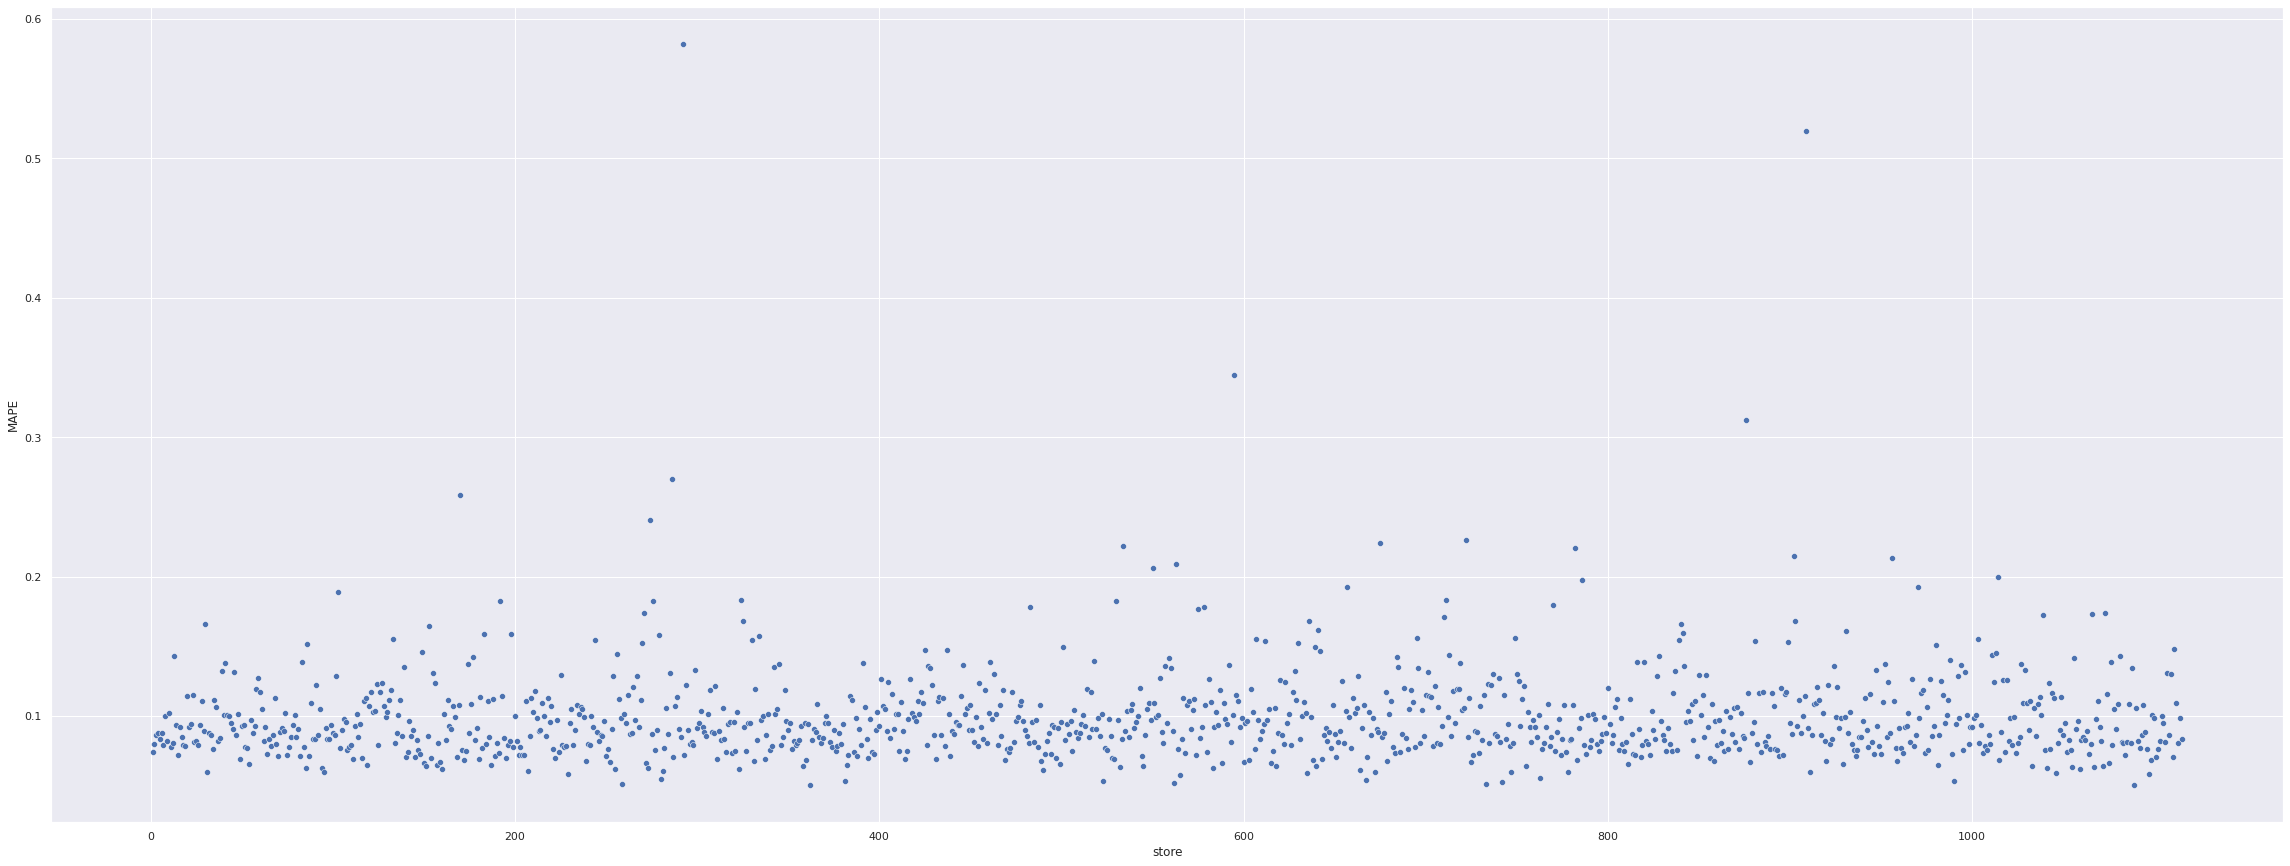

In [103]:
sns.set(rc = {'figure.figsize':(40,15)})

sns.scatterplot(x='store', y='MAPE', data=df92);

## Total Performance

In [104]:
df93 =df92[['predictions', 'worst_scenario', 'best_scenario']].apply(
                                    lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'values'})

df93['values'] = df93['values'].map('R${:,.2f}'.format)

In [105]:
df93.head()

,Scenario,values
0,predictions,"R$285,718,528.00"
1,worst_scenario,"R$284,968,124.55"
2,best_scenario,"R$286,468,949.88"


## Machine Learning Performance

Criando algumas colunas para conseguir plotar alguns graficos com o resultado

In [106]:
#Diferença do erro
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

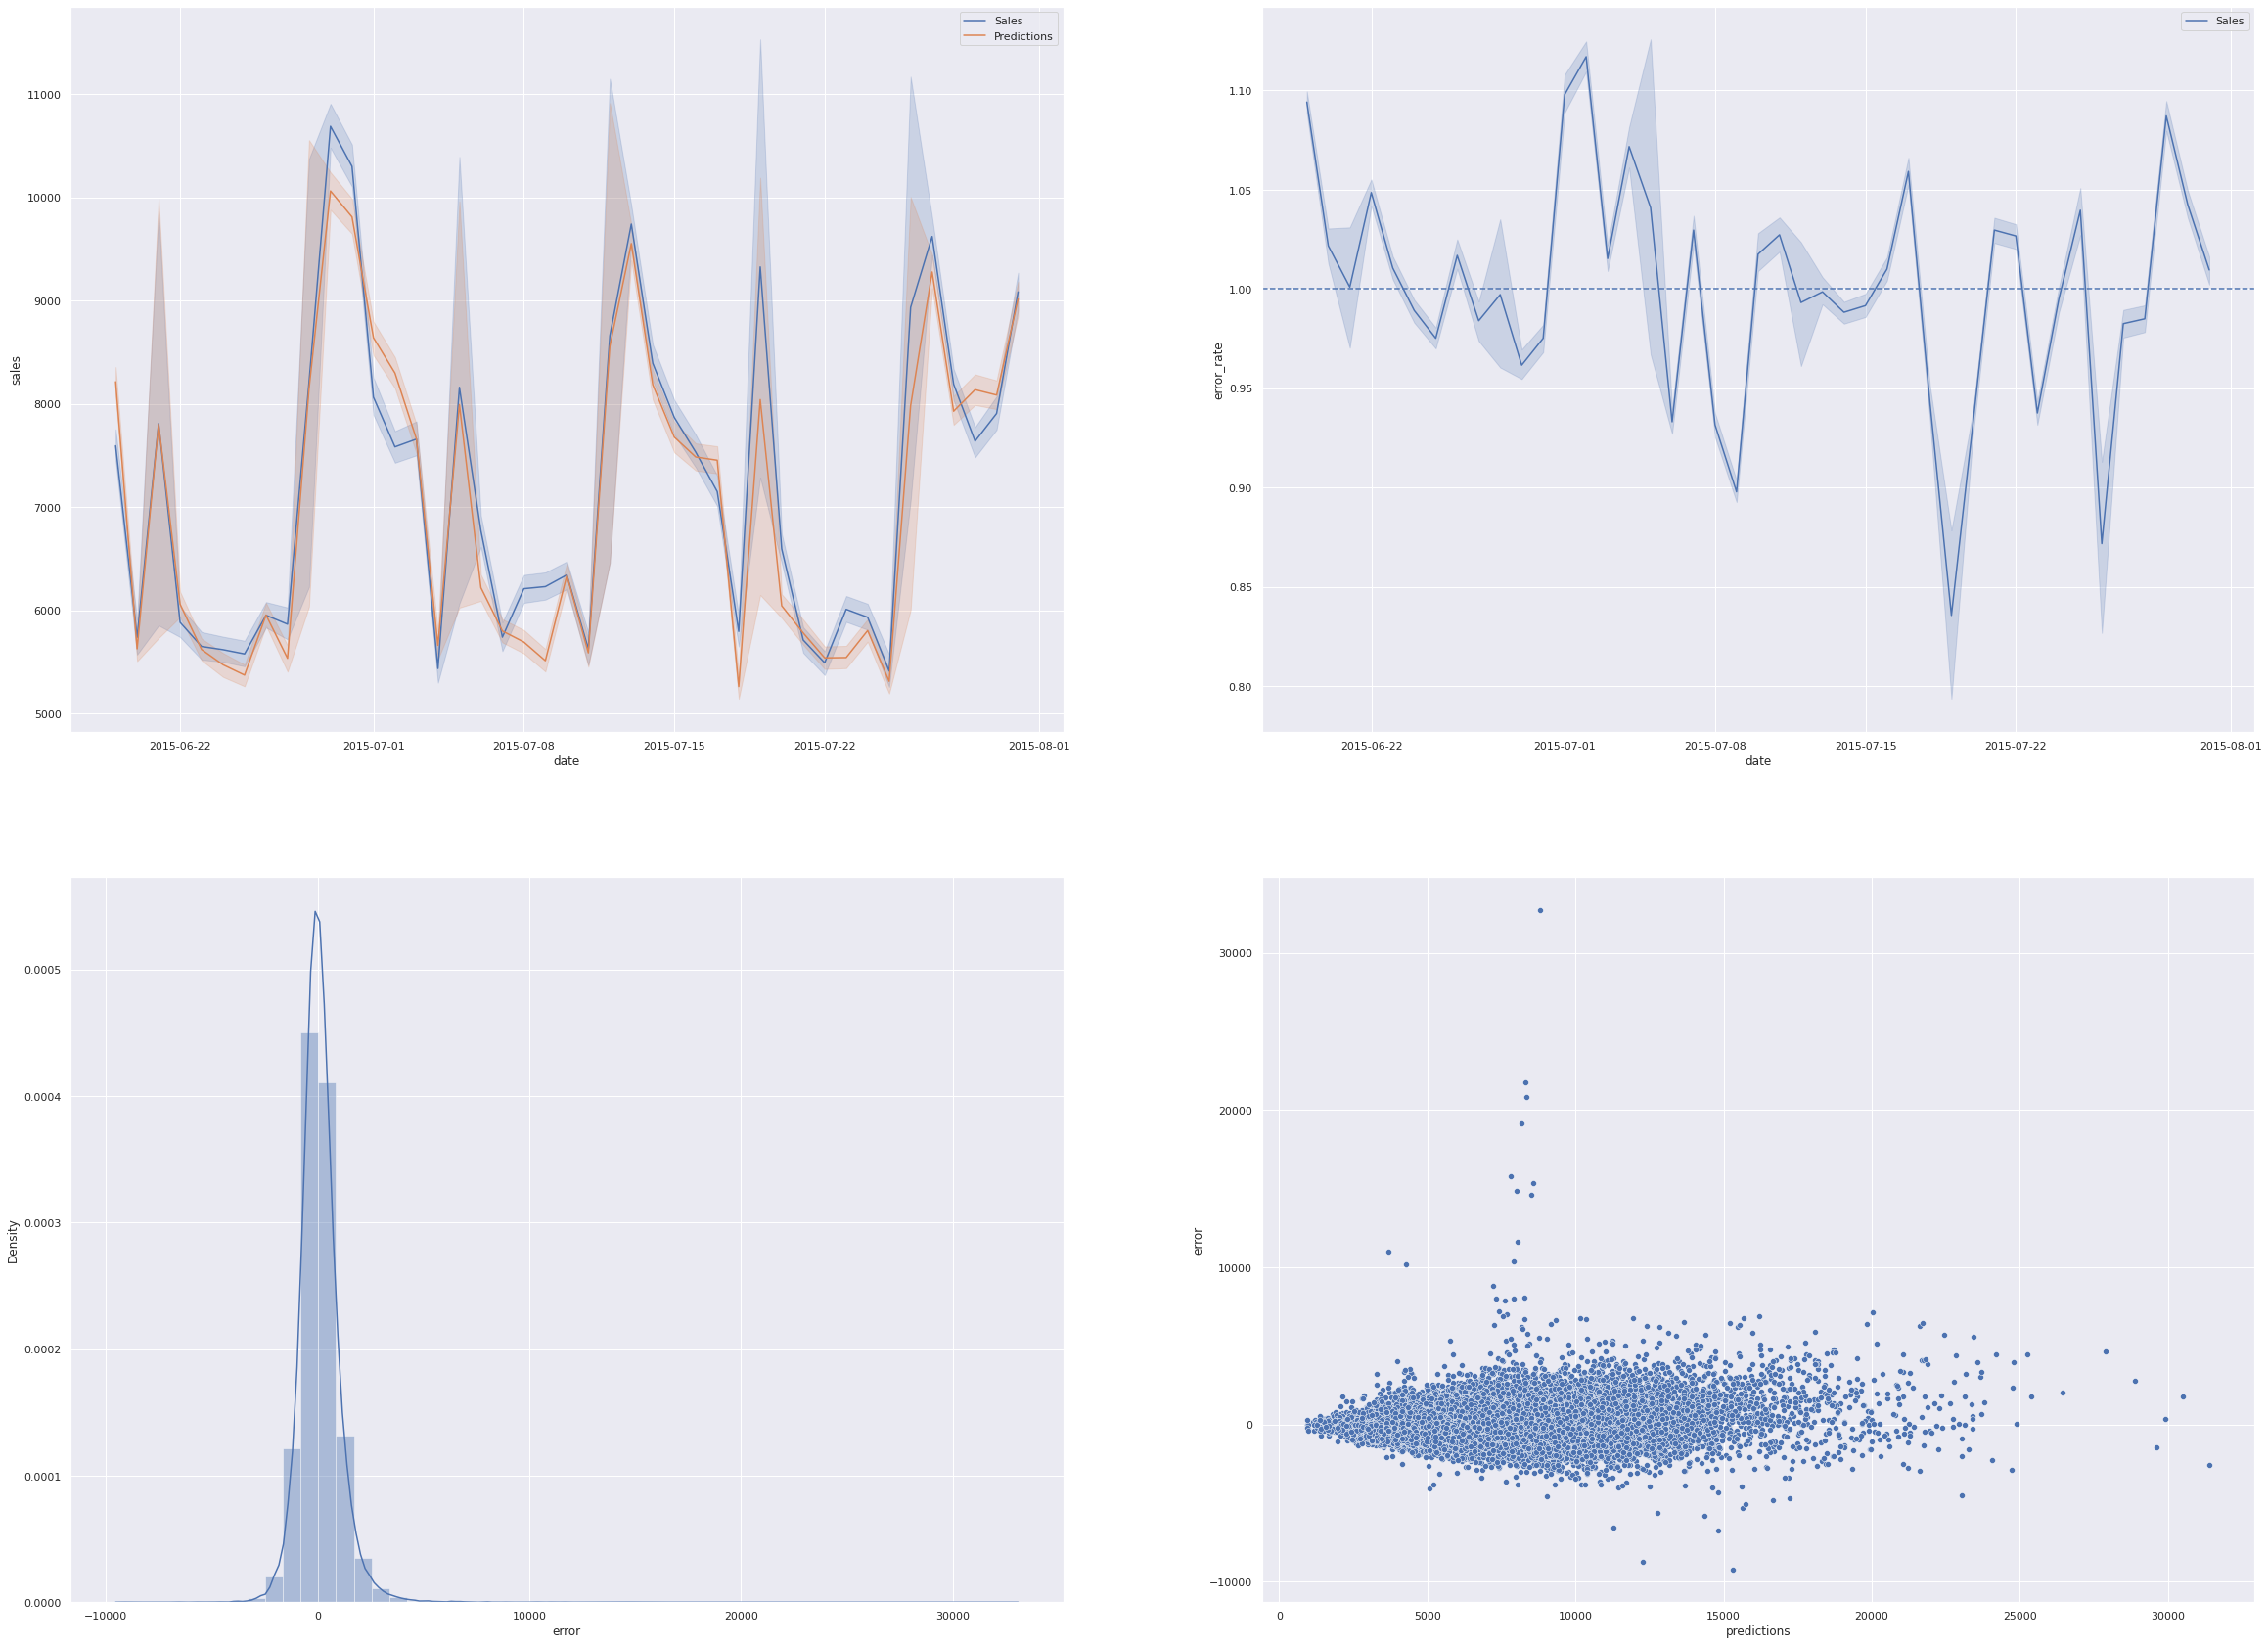

In [107]:
sns.set(rc = {'figure.figsize':(40,30)})

plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='Sales')
sns.lineplot(x='date', y='predictions', data=df9, label='Predictions')

#Grafico onde mostra a superestimendo ou subestimado, acima do 1 modelo prevendo acima da venda real, abaixo do 1 modelo prevendo
#abaixo das venda real(Subestimação)
plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9, label='Sales')
plt.axhline(1, linestyle= '--')

#Grafico fala sobre a distirbuição do erro
plt.subplot(2,2,3)
sns.distplot(df9['error'])

# O erro precisa ficar dentro de um tubo (Analise de residuo)
plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error']);



In [109]:
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_cos,month_sin,day_sin,day_cos,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales,predictions,error,error_rate
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,5263.0,5754.917969,-491.917969,1.093467
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,6064.0,5905.024414,158.975586,0.973784
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,8314.0,9347.356445,-1033.356445,1.124291
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,13995.0,11767.450195,2227.549805,0.840832
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,4822.0,6422.462891,-1600.462891,1.331909


## Sale at the end of 6 weeks

In [111]:
df2 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

for i in range(len( df2 )):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(df2.loc[i, 'store'], df2.loc[i, 'predictions']))

Store Number 1 will sell R$164,688.28 in the next 6 weeks
Store Number 2 will sell R$179,003.42 in the next 6 weeks
Store Number 3 will sell R$265,977.97 in the next 6 weeks
Store Number 4 will sell R$340,788.53 in the next 6 weeks
Store Number 5 will sell R$174,244.72 in the next 6 weeks
Store Number 6 will sell R$178,824.88 in the next 6 weeks
Store Number 7 will sell R$341,523.25 in the next 6 weeks
Store Number 8 will sell R$212,799.73 in the next 6 weeks
Store Number 9 will sell R$267,989.34 in the next 6 weeks
Store Number 10 will sell R$205,437.03 in the next 6 weeks
Store Number 11 will sell R$279,947.09 in the next 6 weeks
Store Number 12 will sell R$272,501.66 in the next 6 weeks
Store Number 13 will sell R$183,187.17 in the next 6 weeks
Store Number 14 will sell R$203,804.92 in the next 6 weeks
Store Number 15 will sell R$256,665.03 in the next 6 weeks
Store Number 16 will sell R$282,711.28 in the next 6 weeks
Store Number 17 will sell R$224,949.00 in the next 6 weeks
Store 